In [ ]:
#save to: /PROJECTS/Swell/Waves+Wind+Station_Data_2025-GridMed_v2.ipynb

Mar 2025: Waves (Pk Per, Sign Wave Height), Station Data (Vertical HP & Swell-band Velocities), Wind (GIL vs WWIII)
#run on ERA5 environment

Wavewatch III Data Download: https://pae-paha.pacioos.hawaii.edu/erddap/griddap/ww3_global.html 

https://erddap.aoml.noaa.gov/hdb/erddap/griddap/WaveWatch_2014.html (2014

https://erddap.aoml.noaa.gov/hdb/erddap/griddap/WaveWatch_2015.html (2015) 

https://erddap.aoml.noaa.gov/hdb/erddap/griddap/WaveWatch_2016.html (2016)

// From WaveWatch III site

Variables

Tdir (peak wave direction, degrees)
Tper (peak wave period, second)
Thgt (significant wave height, meters)
sdir (swell peak wave direction, degrees)
sper (swell peak wave period, seconds)
shgt (swell significant wave height, meters)
wdir (wind peak wave direction, degrees)
wper (wind peak wave period, seconds)
whgt (wind significant wave height, meters)


In [ ]:
# run on ERA5 environment
# next: download your own .nc file

import netCDF4 as nc
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from datetime import datetime
import pandas as pd
import matplotlib.path as mpath
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches

# File paths
file_paths = [
    #'/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_BOX1_GRID_25_HR2.csv'  # West (DR01) 2015
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'  # West Corridor (DR01) 2015
    #'/Users/em/PROJECTS/Swell/DATA/WaveWatch_2016_JanMar_All_BOX1_GRID_25_HR2.csv'  # West (DR01) 2016
]

# Define locations corresponding to file order
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with two rows of subplots (Large plot + Small plot)
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True, 
                         gridspec_kw={'height_ratios': [2, 1]})  # Smaller height for the bottom subplot

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'time_UTC2' is properly converted to datetime
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])  # Convert to Matplotlib-compatible format

    # Main Left y-axis (Peak Period)
    axes[i].bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
                color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    axes[i].set_ylabel('Peak Period (s)', color='black', fontsize=14)
    axes[i].tick_params(axis='y', labelcolor='black', labelsize=14) 
    axes[i].grid(True)

    # First Right y-axis (Significant Wave Height)
    ax_right = axes[i].twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_max_med_avg_hr'], #Thgt_m_med_hr, Thgt_m_max_med_avg_hr
                  '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height Midpoint (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    ax_right.set_ylim([0, 5.5])
    
    # Second Right y-axis (Outer Right: Highpass Vertical Avg)
    ax_outer_right = axes[i].twinx()
    ax_outer_right.plot(data['time_UTC2_num'], data['midband_vert_hourly_avg'], #midband_hourly_avg #highpass_vert_hourly_avg, midband_vert_hourly_avg
                        '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (m/s)")
    ax_outer_right.set_ylabel('1-2 Hz Band Velocity (m/s)', color='purple', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)  

    # Move the second right axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('red')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Add text for location
    axes[i].text(0.05, 0.95, locations[i], transform=axes[i].transAxes, 
                 fontsize=15, fontweight='bold', color='black', 
                 verticalalignment='top', horizontalalignment='left')

    # Set x-axis limits and formatting
    axes[i].set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Small subplot for Swell-band and Highpass Vertical Velocity (hourly avg)
ax_small = axes[-1]  # The last subplot is the small one

ax_small.plot(data['time_UTC2_num'], data['swellband_vert_hourly_avg'], 'k--', label="Vert SB Velocity (m/s)")
ax2_small = ax_small.twinx()
ax2_small.plot(data['time_UTC2_num'], data['highpass_vert_hourly_avg'], 'r-', label="Vert HP Velocity (m/s)")

# Increase tick label size # Increase y-axis label size
ax2_small.tick_params(axis='both', which='major', labelsize=14)  
ax_small.tick_params(axis='both', which='major', labelsize=14)
ax2_small.set_ylabel("Vertical Highpass \n Velocity (m/s)", color="r", fontsize=14)  

ax_small.set_ylabel("Vertical Swell-band \n Velocity (m/s)", color="k", fontsize=14)  
ax2_small.set_ylabel("Vertical Highpass \n Velocity (m/s)", color="r", fontsize=14)  
#ax_small.set_title("Vertical Component Swell-band and Highpass Velocity (hourly average)")

# shade small subplot when Tper_s_med_hr > 8
for t_start, t_end, tper in zip(data['time_UTC2_num'][:-1], data['time_UTC2_num'][1:], data['Tper_s_max_hr'][:-1]): #Tper_s_med_hr
    if tper > 8:
        ax_small.axvspan(t_start, t_end, facecolor='lightblue', alpha=0.3, zorder=0)

gray_patch = mpatches.Patch(color='lightblue', alpha=0.3, label='Peak Wave Period \n is Swell Per. (> 8s)')

# Add the legend to the small subplot
ax_small.legend(handles=[gray_patch], loc='upper left', frameon=True, fontsize=14)

# scientific notation for the left y-axis
formatter = mticker.ScalarFormatter(useMathText=True)  # Use math-style scientific notation
formatter.set_scientific(True)
formatter.set_powerlimits((-2, 2))  # Force scientific notation for small numbers
ax_small.yaxis.set_major_formatter(formatter)  # Apply to left y-axis

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.subplots_adjust(hspace=0.1)

#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/PkPerSWH_StaVert_2015_DR01WestChannel_midpt+1-2HzVert.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_BOX1_GRID_25_HR2.csv'  # West (DR01) 2015
]

# Define locations corresponding to file order
locations = ["West Sector WaveWatch III & Station DR01"]

# Set up the figure with a single subplot
fig, ax = plt.subplots(figsize=(15, 6))

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'time_UTC2' is properly converted to datetime
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])  # Convert to Matplotlib-compatible format

    # Convert swell-band and highpass velocity to dB
    data['swellband_dB'] = 20 * np.log10(np.abs(data['swellband_vert_hourly_avg']))
    data['highpass_dB'] = 20 * np.log10(np.abs(data['highpass_vert_hourly_avg']))

    # Main Left y-axis (Peak Period) - Line Plot
    ax.plot(data['time_UTC2_num'], data['Tper_s_med_hr'], '-', color='purple', linewidth=2, label="Peak Period (s)")
    ax.set_ylabel('Peak Period (s)', color='purple', fontsize=14)
    ax.tick_params(axis='y', labelcolor='purple', labelsize=14)
    ax.grid(True)
    ax.set_ylim([0, 10])

    # First Right y-axis (Significant Wave Height)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_med_hr'], '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax_right.set_ylim([0, 2])

    # Second Right y-axis (Outer Right: Highpass Velocity in dB)
    ax_outer_right = ax.twinx()
    ax_outer_right.plot(data['time_UTC2_num'], data['highpass_dB'], '-', color='red', linewidth=2, label="Highpass Velocity (dB)")
    ax_outer_right.set_ylabel('Highpass Velocity (dB re 1 m/s)', color='red', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='red', labelsize=14)
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('red')
    ax_outer_right.set_ylim([-128,-122])

    # Outer Left y-axis (Swell-band Velocity in dB)
    ax_outer_left = ax.twinx()
    ax_outer_left.spines['left'].set_position(('outward', 60))  # Move to the left
    ax_outer_left.spines['left'].set_color('black')
    ax_outer_left.yaxis.set_label_position('left')  # Ensure label is on the left
    ax_outer_left.yaxis.set_ticks_position('left')  # Ensure ticks are on the left
    ax_outer_left.plot(data['time_UTC2_num'], data['swellband_dB'], 'k--', linewidth=2, label="Swell-band Velocity (dB)")
    ax_outer_left.set_ylabel('Swell-band Velocity (dB re 1 m/s)', color='black', fontsize=14)
    ax_outer_left.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_outer_left.set_ylim([-90,-60])
    
    # Add text for location
    ax.text(0.99, 0.95, locations[i], transform=ax.transAxes, fontsize=15, fontweight='bold', color='black',
            verticalalignment='top', horizontalalignment='right')

    # Set x-axis limits and formatting
    start_date_filter = pd.to_datetime("2015-01-28 00:00:00")
    end_date_filter = pd.to_datetime("2015-01-31 00:00:00")
    start_date_num = mdates.date2num(start_date_filter)
    end_date_num = mdates.date2num(end_date_filter)
    ax.set_xlim([start_date_num, end_date_num])
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%-m-%d-%y\n %H:%MZ'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)
plt.savefig('/Users/em/PROJECTS/Swell/FIGS/PkPerSWH_StaVert_282930Jan2015_DR01West_GRIDmed.png', format='png', dpi=600, bbox_inches='tight')
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/Users/em/PROJECTS/Wind/GIL_2015_Jan1toMar15_hravg_dec_2.csv"

# Read the CSV file
data = pd.read_csv(file_path, delimiter=",", decimal=".")

# Convert 'day' and 'hour' to numeric
data["day"] = pd.to_numeric(data["day"], errors="coerce")
data["hour"] = pd.to_numeric(data["hour"], errors="coerce")

# Remove rows with NaN in 'day'
data = data.dropna(subset=["day"])

# Convert 'day' and 'hour' into a proper datetime format
start_date = pd.to_datetime("2015-01-01")
data["datetime"] = start_date + pd.to_timedelta(data["day"] - 1, unit="D") + pd.to_timedelta(data["hour"], unit="H")

# Convert 'windspeed_ms' to numeric
data["windspeed_ms"] = pd.to_numeric(data["windspeed_ms"], errors="coerce")

# Define the manual date range for plotting
start_date_filter = pd.to_datetime("2015-01-01")
end_date_filter = pd.to_datetime("2015-03-16")

# Filter data within the selected date range
data_filtered = data[(data["datetime"] >= start_date_filter) & (data["datetime"] <= end_date_filter)]

# Plot setup
fig, ax = plt.subplots(figsize=(12.35, 1.8))  # Equivalent figure size

ax.plot(data_filtered["datetime"], data_filtered["windspeed_ms"], '-', color='blue')
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Windspeed (m/s)", fontsize=12)
ax.set_title(f"Hourly Averaged Windspeed from {start_date_filter.strftime('%b %d')} 2015, 0000Z to "
             f"{end_date_filter.strftime('%b %d')} 2015, 0000Z; GIL: Lat: 79.88S  Lon: 178.57W, 241 km SSW of DR01",
             fontsize=12)

# Format x-axis to show every 10 days
xtick_vals = pd.date_range(start=start_date_filter, end=end_date_filter, freq="10D")
if xtick_vals[-1] != end_date_filter:
    xtick_vals = xtick_vals.append(pd.DatetimeIndex([end_date_filter]))  # Ensure last date is included

ax.set_xticks(xtick_vals)
ax.set_xticklabels([d.strftime('%d-%b') for d in xtick_vals], rotation=90, fontsize=10)

# Manually set x-axis limits to ensure full range is displayed
ax.set_xlim([start_date_filter, end_date_filter])

ax.grid(True)
#plt.savefig('/Users/em/PROJECTS/Wind/FIGS/GILWind_JantoMar2015.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
file_path = "/Users/em/PROJECTS/Wind/GIL_2015_Jan1toMar15_hravg_dec_2.csv"
file_path2 = '/Volumes/CATALOGDR00/MERRA2_DATA/MERRA2_400.inst3_3d_asm_Np.201501282930_uvs_925mbmwind_med_.csv'
# 25 rows in file_path2, starting with 1/28/15 0:00 in the 'time' header, every three hours until 1/30/15 21:00; 
# the second column is 925mb wind, 'median_wind_speed'. How do i add this data to the existing plot, same time series, and on the right y-axis? 


# Read the CSV file
data = pd.read_csv(file_path, delimiter=",", decimal=".")

# Convert 'day' and 'hour' to numeric
data["day"] = pd.to_numeric(data["day"], errors="coerce")
data["hour"] = pd.to_numeric(data["hour"], errors="coerce")

# Remove rows with NaN in 'day'
data = data.dropna(subset=["day"])

# Convert 'day' and 'hour' into a proper datetime format
start_date = pd.to_datetime("2015-01-01")
data["datetime"] = start_date + pd.to_timedelta(data["day"] - 1, unit="D") + pd.to_timedelta(data["hour"], unit="H")

# Convert 'windspeed_ms' to numeric
data["windspeed_ms"] = pd.to_numeric(data["windspeed_ms"], errors="coerce")

# Define the manual date range for plotting
start_date_filter = pd.to_datetime("2015-01-28")
end_date_filter = pd.to_datetime("2015-01-30")

# Filter data within the selected date range
data_filtered = data[(data["datetime"] >= start_date_filter) & (data["datetime"] <= end_date_filter)]

# Plot setup
fig, ax = plt.subplots(figsize=(12.35, 1.8))  # Equivalent figure size

ax.plot(data_filtered["datetime"], data_filtered["windspeed_ms"], '-', color='blue')
#ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("AWS Station GIL \n Windspeed (m/s)", fontsize=12, color='blue')
ax.set_title(f"Hourly Averaged Windspeed from {start_date_filter.strftime('%b %d')} 2015, 0000Z to "
             f"{end_date_filter.strftime('%b %d')} 2015, 0000Z; GIL: Lat: 79.88S  Lon: 178.57W, 241 km SSW of DR01",
             fontsize=12)
#ax.set_ylim(0, 12)

# Generate x-axis tick values every 3 hours
xtick_vals = pd.date_range(start=start_date_filter, end=end_date_filter, freq="6H")

# Ensure the last date is included if missing
if xtick_vals[-1] != end_date_filter:
    xtick_vals = xtick_vals.append(pd.DatetimeIndex([end_date_filter]))

# Format labels: Show only the date at 00:00Z, otherwise show only the hour
xtick_labels = [
    d.strftime('%m/%d/%Y') if d.hour == 0 else d.strftime('%H:%MZ') 
    for d in xtick_vals
]

ax.set_xticks(xtick_vals)
ax.set_xticklabels(xtick_labels, rotation=90, fontsize=10)

# Manually set x-axis limits to ensure full range is displayed
ax.set_xlim([start_date_filter, end_date_filter])

ax.grid(True)
plt.savefig('/Users/em/PROJECTS/Wind/FIGS/GILWind_Jan2829302015.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV files
file_path = "/Users/em/PROJECTS/Wind/GIL_2015_Jan1toMar15_hravg_dec_2.csv"
file_path2 = "/Volumes/CATALOGDR00/MERRA2_DATA/MERRA2_400.inst3_3d_asm_Np.201501282930_uvs_925mbmwind_med_.csv"

# Read the first dataset
data = pd.read_csv(file_path, delimiter=",", decimal=".")

# Convert 'day' and 'hour' to numeric
data["day"] = pd.to_numeric(data["day"], errors="coerce")
data["hour"] = pd.to_numeric(data["hour"], errors="coerce")

# Remove rows with NaN in 'day'
data = data.dropna(subset=["day"])

# Convert 'day' and 'hour' into a proper datetime format
start_date = pd.to_datetime("2015-01-01")
data["datetime"] = start_date + pd.to_timedelta(data["day"] - 1, unit="D") + pd.to_timedelta(data["hour"], unit="H")

# Convert 'windspeed_ms' to numeric
data["windspeed_ms"] = pd.to_numeric(data["windspeed_ms"], errors="coerce")

# Read the second dataset
data2 = pd.read_csv(file_path2, delimiter=",", decimal=".")

# Convert 'time' column to datetime format
data2["datetime"] = pd.to_datetime(data2["time"])

# Convert 'median_wind_speed' to numeric
data2["median_wind_speed"] = pd.to_numeric(data2["median_wind_speed"], errors="coerce")

# Define the manual date range for plotting
start_date_filter = pd.to_datetime("2015-01-28")
end_date_filter = pd.to_datetime("2015-01-31")

# Filter both datasets within the selected date range
data_filtered = data[(data["datetime"] >= start_date_filter) & (data["datetime"] <= end_date_filter)]
data2_filtered = data2[(data2["datetime"] >= start_date_filter) & (data2["datetime"] <= end_date_filter)]

# Plot setup
fig, ax = plt.subplots(figsize=(12.35, 1.8))

# Plot first dataset (AWS wind speed) on the primary y-axis
ax.plot(data_filtered["datetime"], data_filtered["windspeed_ms"], '-', color='blue', label="AWS Wind Speed")
ax.set_ylabel("AWS Station GIL \n Windspeed (m/s)", fontsize=12, color='blue')

# Create secondary y-axis
ax2 = ax.twinx()

# Plot second dataset (925mb wind) on the secondary y-axis
ax2.plot(data2_filtered["datetime"], data2_filtered["median_wind_speed"], '--', color='green', label="925mb Wind Speed")
ax2.set_ylabel("925mb MERRA-2 \n Wind Speed (m/s)", fontsize=12, color='green')

# Set title
#ax.set_title(f"Hourly Averaged Windspeed from {start_date_filter.strftime('%b %d')} 2015, 0000Z to "
#             f"{end_date_filter.strftime('%b %d')} 2015, 0000Z; GIL: Lat: 79.88S  Lon: 178.57W, 241 km SSW of DR01, and 925 mb MERRA-2 Spatial Median Windspeed",
#             fontsize=12)

# Set title with line breaks
ax.set_title(f"Hourly Averaged Windspeed from {start_date_filter.strftime('%b %d')} 2015, 0000Z to "
             f"{end_date_filter.strftime('%b %d')} 2015, 0000Z\n"
             "GIL: Lat: 79.88S  Lon: 178.57W, 241 km SSW of DR01\n"
             "and 925 mb MERRA-2 Spatial Median Windspeed, Area near DR01\n",
             fontsize=12)

# Generate x-axis tick values every 6 hours
xtick_vals = pd.date_range(start=start_date_filter, end=end_date_filter, freq="6H")

# Ensure the last date is included if missing
if xtick_vals[-1] != end_date_filter:
    xtick_vals = xtick_vals.append(pd.DatetimeIndex([end_date_filter]))

# Format labels: Show only the date at 00:00Z, otherwise show only the hour
xtick_labels = [
    d.strftime('%m/%d/%Y') if d.hour == 0 else d.strftime('%H:%MZ') 
    for d in xtick_vals
]

ax.set_xticks(xtick_vals)
ax.set_xticklabels(xtick_labels, rotation=90, fontsize=10)

# Manually set x-axis limits to ensure full range is displayed
ax.set_xlim([start_date_filter, end_date_filter])

ax.grid(True)

# Save and show the figure
plt.savefig('/Users/em/PROJECTS/Wind/FIGS/GIL+MERRA2Wind_Jan2829302015.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


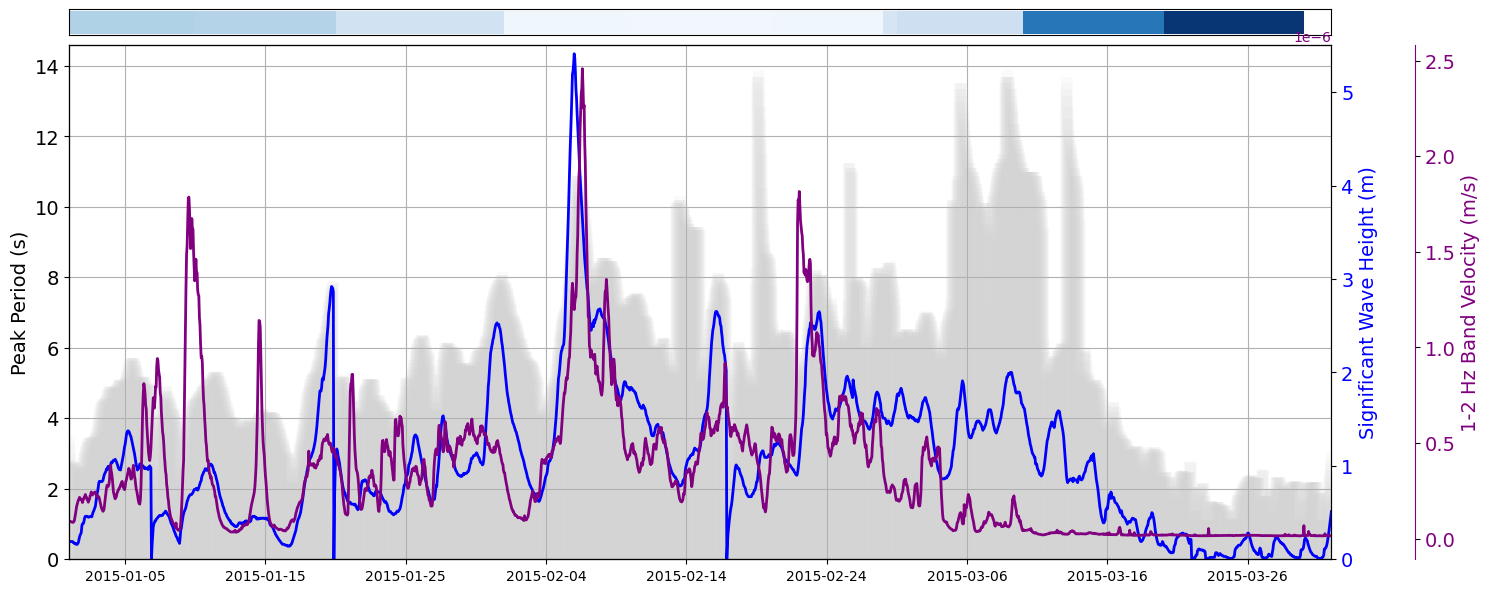

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'  # West Corridor (DR01) 2015
]

# Define locations corresponding to file order
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with only one subplot
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'time_UTC2' is properly converted to datetime
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])  # Convert to Matplotlib-compatible format

    # Main Left y-axis (Peak Period)
    ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
           color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    ax.tick_params(axis='y', labelcolor='black', labelsize=14) 
    ax.grid(True)

    # First Right y-axis (Significant Wave Height)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_med_hr'],
                  '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    ax_right.set_ylim([0, 5.5])
    
    # Second Right y-axis (Outer Right: Highpass Vertical Avg)
    ax_outer_right = ax.twinx()
    ax_outer_right.plot(data['time_UTC2_num'], data['midband_vert_hourly_avg'],
                        '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (m/s)")
    ax_outer_right.set_ylabel('1-2 Hz Band Velocity (m/s)', color='purple', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)  

    # Move the second right axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('purple')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelf_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    # Filter to match your WaveWatch date range
    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    
    # Convert time to Matplotlib date format
    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    
    # Normalize sea ice percent for colormap
    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    
    # Add color strip above the main plot
    strip_ax = ax.inset_axes([0, 1.02, 1, 0.05])  # x0, y0, width, height
    strip_ax.set_xlim(ax.get_xlim())
    strip_ax.set_xticks([])
    strip_ax.set_yticks([])
    
    # Draw colored segments for sea ice
    for i in range(len(sea_ice_df_near) - 1):
        if pd.isna(sea_ice_df_near['perc_non_black'].iloc[i]):
            continue
        strip_ax.fill_between(
            [sea_ice_df_near['time_num'].iloc[i], sea_ice_df_near['time_num'].iloc[i + 1]],
            0, 1, color=colors[i], linewidth=0
        )
    
    # Add colorbar for sea ice
    #sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    #sm.set_array([])
    #cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.12, aspect=40)
    #cbar.set_label('Near-Front Region Sea Ice Concentration > 25%', fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/PkPerSWH_StaVert_2015_DR01WestChannel_midpt+1-2HzVert_.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


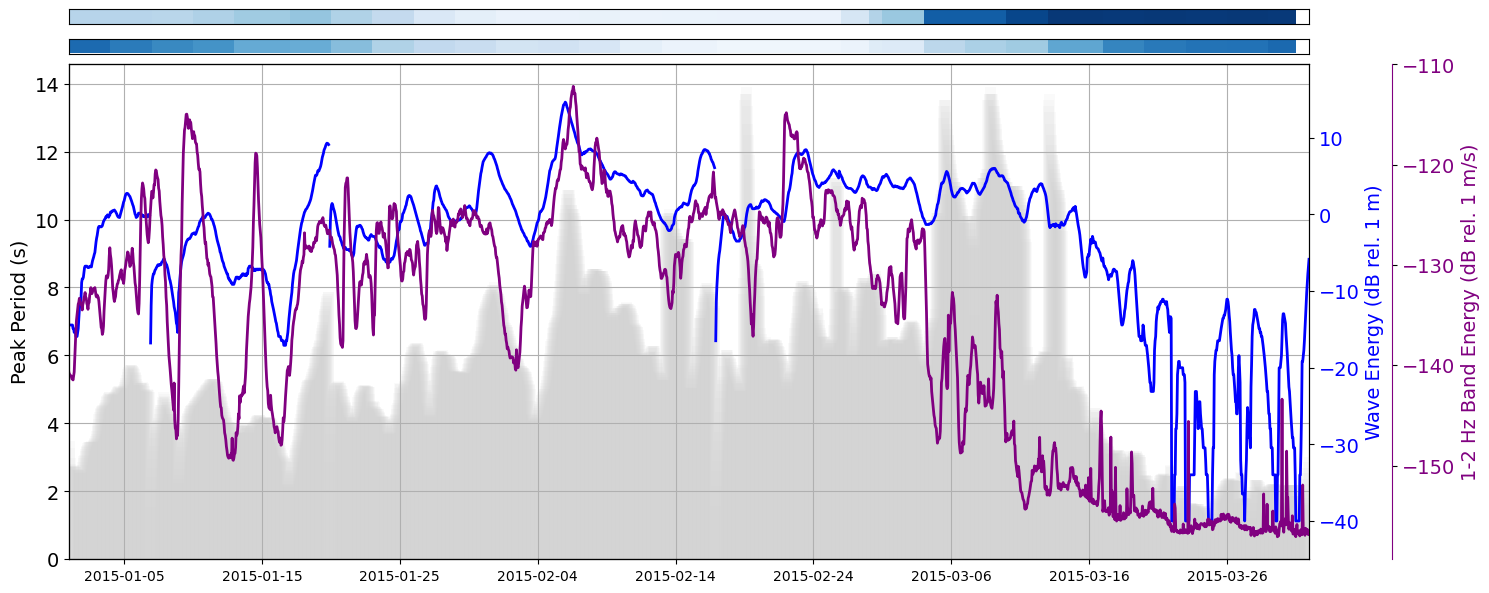

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'  # West Corridor (DR01) 2015
]

# Define locations corresponding to file order
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with only one subplot
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'time_UTC2' is properly converted to datetime
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])  # Convert to Matplotlib-compatible format

    # Main Left y-axis (Peak Period)
    ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
           color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    ax.tick_params(axis='y', labelcolor='black', labelsize=14) 
    ax.grid(True)

    # First Right y-axis (Significant Wave Height)
    #ax_right = ax.twinx()
    #ax_right.plot(data['time_UTC2_num'], data['Thgt_m_max_med_avg_hr'],
    #              '-', color='blue', linewidth=2, label="Wave Height")
    #ax_right.set_ylabel('Significant Wave Height Midpoint (m)', color='blue', fontsize=14)
    #ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    #ax_right.set_ylim([0, 5.5])
    
    # Second Right y-axis (Outer Right: Midband Vertical Avg)
    #ax_outer_right = ax.twinx()
    #ax_outer_right.plot(data['time_UTC2_num'], data['midband_vert_hourly_avg'],
    #                    '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (m/s)")
    #ax_outer_right.set_ylabel('1-2 Hz Band Energy (m/s)', color='purple', fontsize=14)
    #ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)  


    #~~~ to plot Energy in dB: 

    # Compute wave energy in dB
    wave_energy = data['Thgt_m_med_hr'] ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 10 * np.log10(wave_energy)
    
    # First Right y-axis (Wave Energy in dB)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], wave_energy_dB,
                  '-', color='blue', linewidth=2, label="Wave Energy")
    ax_right.set_ylabel('Wave Energy (dB rel. 1 m)', color='blue', fontsize=14) # from Significant Wave Height Midpoint 
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    ax_right.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])  # Adjust as needed
    
    # Second Right y-axis (Outer Right: Seismic Velocity in dB)
    ax_outer_right = ax.twinx()
    
    velocity = data['midband_vert_hourly_avg'].copy()
    velocity[velocity <= 0] = np.nan
    velocity_dB = 20 * np.log10(velocity)
    
    ax_outer_right.plot(data['time_UTC2_num'], velocity_dB,
                    '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (dB)")
    ax_outer_right.set_ylabel('1-2 Hz Band Energy (dB rel. 1 m/s)', color='purple', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)

    #~~~ end dB plot option

    # Move the second right axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('purple')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])
    
    # Filter by WaveWatch date range
    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()
    
    # Convert to matplotlib time format
    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])
    
    # Normalize color scale for both
    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))
    
    # --- Add horizontal color strips ---
    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])  # top strip (near front)
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])  # lower strip (west corridor)
    
    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], 
                                    [sea_ice_df_near, sea_ice_df_west], 
                                    [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/PkPerSWH_StaVert_2015_DR01WestChannel_midpt+1-2HzVert_SIC.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


In [6]:
# plot three band passes instead of one

#~~~

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'  # West Corridor Nearshore (DR01) 2015 
]
# Grid 1, Nearshore DR01: -72 to -76.5, 170 to 178.5 WEST CORRIDOR 2 (...WEST2_25.csv)

# Define locations corresponding to file order
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with only one subplot
fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    # Load data
    data = pd.read_csv(file_path)

    # Ensure 'time_UTC2' is properly converted to datetime
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])  # Convert to Matplotlib-compatible format

    # Main Left y-axis (Peak Period)
    ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
           color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    ax.tick_params(axis='y', labelcolor='black', labelsize=14) 
    ax.grid(True)

    # First Right y-axis (Significant Wave Height)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_med_hr'],
                  '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    ax_right.set_ylim([0, 5.5])
    
    # Second Right y-axis (Outer Right: Midband Vertical Avg)
    #ax_outer_right = ax.twinx()
    #ax_outer_right.plot(data['time_UTC2_num'], data['midband_vert_hourly_avg'],
                        '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (m/s)")
    #ax_outer_right.set_ylabel('1-2 Hz Band Energy (m/s)', color='purple', fontsize=14)
    #ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)  

    #~~~ to plot Energy in dB: 

    # Compute wave energy in dB
    #wave_energy = data['Thgt_m_med_hr'] ** 2
    #wave_energy[wave_energy <= 0] = np.nan
    #wave_energy_dB = 10 * np.log10(wave_energy)
    
    # First Right y-axis (Wave Energy in dB)
    #ax_right = ax.twinx()
    #ax_right.plot(data['time_UTC2_num'], wave_energy_dB,
    #              '-', color='blue', linewidth=2, label="Wave Energy")
    #ax_right.set_ylabel('Wave Energy (dB rel. 1 m)', color='blue', fontsize=14) # from Significant Wave Height Midpoint 
    #ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)  
    #ax_right.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])  # Adjust as needed
    
    # Second Right y-axis (Outer Right: Seismic Velocity in dB)
    #ax_outer_right = ax.twinx()
    #velocity = data['midband_vert_hourly_avg'].copy()
    #velocity[velocity <= 0] = np.nan
    #velocity_dB = 20 * np.log10(velocity)
    #ax_outer_right.plot(data['time_UTC2_num'], velocity_dB,
    #                '-', color='purple', linewidth=2, label="1-2 Hz Band Velocity (dB)")
    #ax_outer_right.set_ylabel('1-2 Hz Band Energy (dB rel. 1 m/s)', color='purple', fontsize=14)
    #ax_outer_right.tick_params(axis='y', labelcolor='purple', labelsize=14)

    #~~~ end dB plot option

    #~~~ insert three bandpasses option

    # Second Right y-axis (Seismic Velocity in dB)
    ax_outer_right = ax.twinx()
    
    # Plot all three bands on the same axis
    bands = {
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'purple'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'orange'),
    }
    
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        #ax_outer_right.plot(data['time_UTC2_num'], velocity_dB, '-', label=f'{label} Velocity (dB)', color=color, linewidth=2)
        ax_outer_right.plot(data['time_UTC2_num'], velocity, '-', label=f'{label} Velocity', color=color, linewidth=2)
        
    # Set a single y-axis label for seismic velocity
    #x_outer_right.set_ylabel('Seismic Velocity Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_outer_right.set_ylabel('Seismic Velocity Energy (sqrt (m/s)^2)', color='black', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    
    # Add a legend to show all 3 bands
    ax_outer_right.legend(loc='upper right', fontsize=10)
    ax_outer_right.set_ylim([-310, -50])

    #~~~ end three bandpasses option

    # Move the second right axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('black')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])
    
    # Filter by WaveWatch date range
    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()
    
    # Convert to matplotlib time format
    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])
    
    # Normalize color scale for both
    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))
    
    # --- Add horizontal color strips ---
    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])  # top strip (near front)
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])  # lower strip (west corridor)
    
    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], 
                                    [sea_ice_df_near, sea_ice_df_west], 
                                    [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/PkPerSWH_StaVert_2015_DR01WestChannel_midpt+1-2HzVert_SIC.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 91)

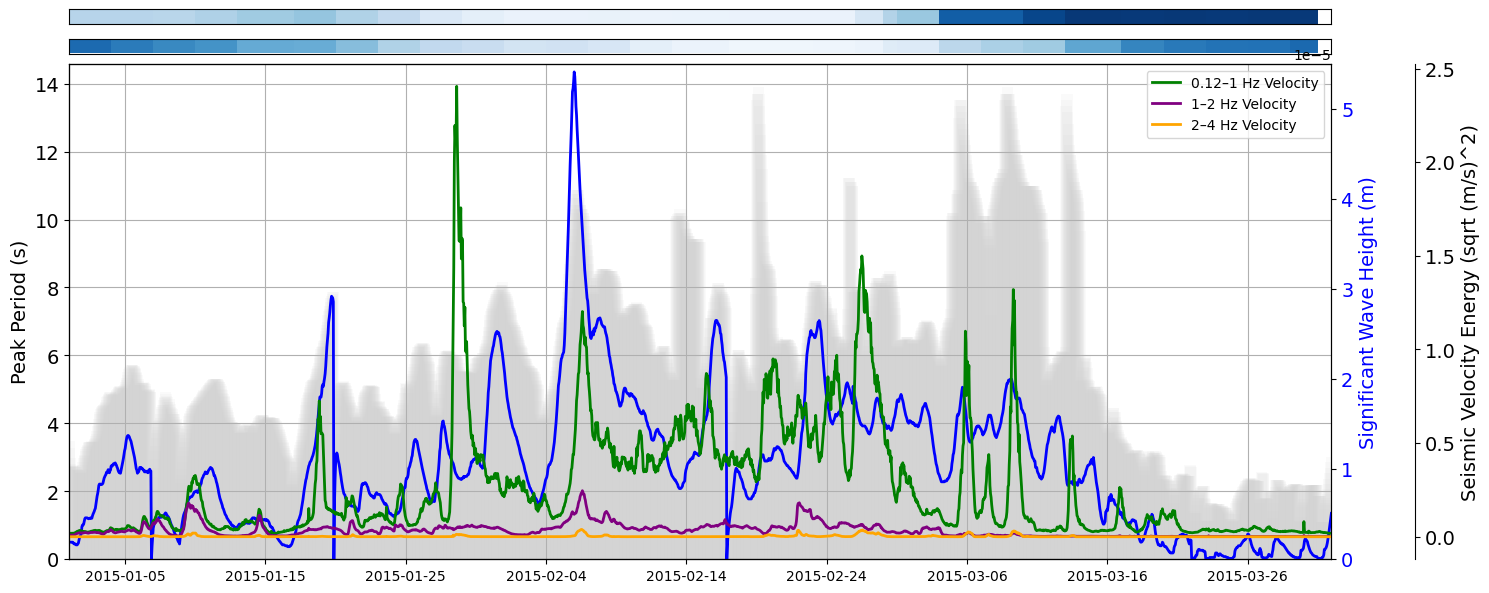

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with only one subplot
fig, ax = plt.subplots(figsize=(15, 6))

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Left y-axis (Peak Period)
    ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
           color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax.grid(True)

    # Right y-axis (Significant Wave Height)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_med_hr'],
                  '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax_right.set_ylim([0, 5.5])

    # Outer right y-axis (Three band velocity)
    ax_outer_right = ax.twinx()

    # Move the outer axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('black')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Plot velocity directly
    bands = {
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'purple'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'orange'),
    }

    for column, (label, color) in bands.items():
        if column in data.columns:
            velocity = data[column].copy()
            velocity[velocity <= 0] = np.nan
            ax_outer_right.plot(data['time_UTC2_num'], velocity,
                                '-', label=f'{label} Velocity', color=color, linewidth=2)

    ax_outer_right.set_ylabel('Seismic Velocity Energy (sqrt (m/s)^2)', color='black', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_outer_right.legend(loc='upper right', fontsize=10)
    # ax_outer_right.set_ylim([-310, -50])  # Commented out — applies to dB scale, not velocity

    # X-axis formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    # Filter sea ice data
    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    # Sea ice strips
    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], 
                                    [sea_ice_df_near, sea_ice_df_west], 
                                    [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

# Final plot touches
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('your_output_path.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


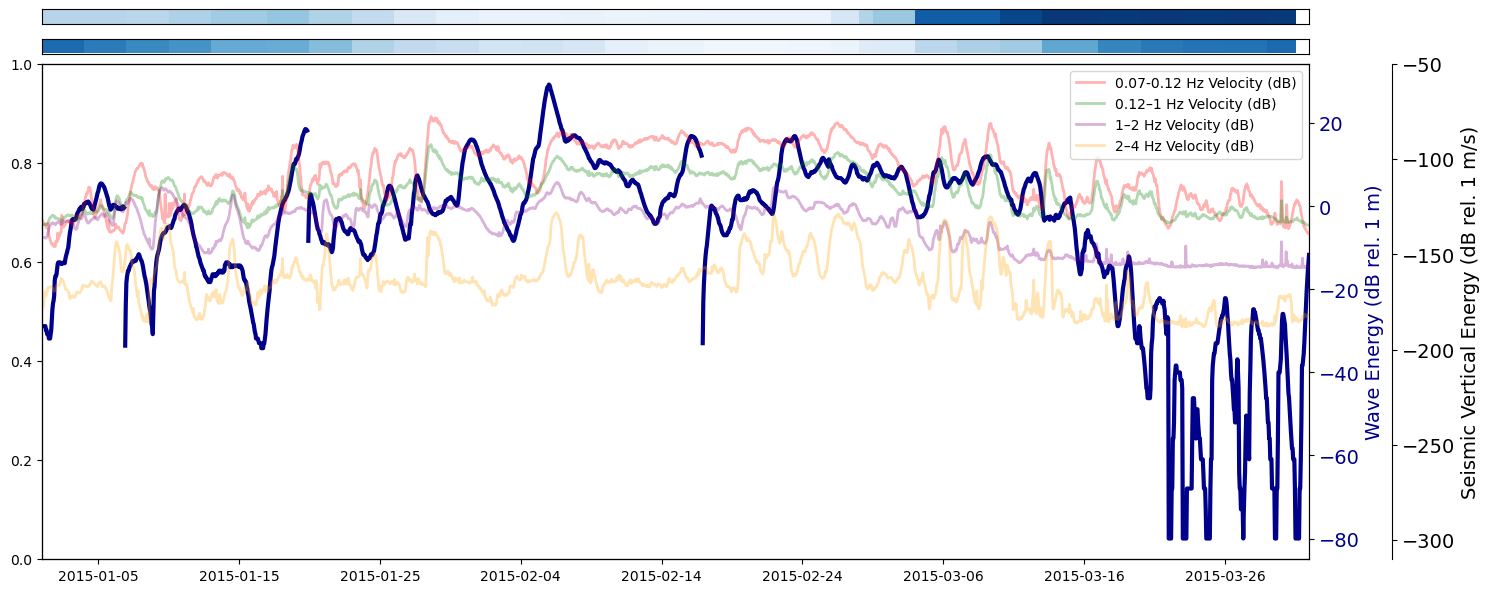

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Convert Significant Wave Height to energy in dB (10 * log10(H^2))
    wave_height = data['Thgt_m_med_hr'].copy()
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # First Right y-axis: Wave Energy in dB
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], wave_energy_dB,
                  '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax_right.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    ax_right.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])

    # Second Right y-axis: Seismic Velocity Bands in dB
    ax_outer_right = ax.twinx()
    bands = {
        #'swellloband_hourly_avg': ('0.03-0.06 Hz', 'black'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'red'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'purple'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'orange'),
    }

    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_outer_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label} Velocity (dB)', 
            color=color,
            linewidth=2,
            alpha=0.3  # Adjust this value (0.0 to 1.0) for desired transparency
        )
    ax_outer_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_outer_right.legend(loc='upper right', fontsize=10)
    ax_outer_right.set_ylim([-310, -50])
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('black')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], [sea_ice_df_near, sea_ice_df_west], [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('your_output_path.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


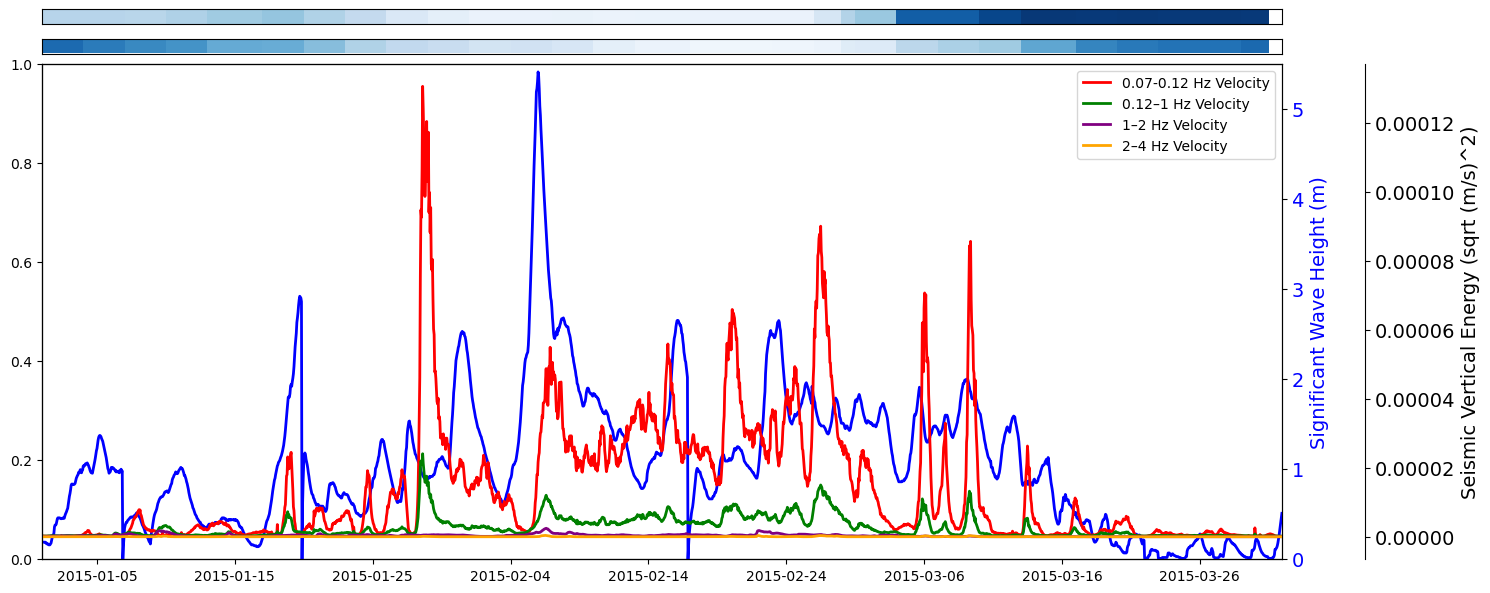

In [9]:
# add swellhiband_hourly_avg, swellloband_hourly_avg 0.07-0.12 & 0.03-0.06
# add subplot for wind

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = [" 2015 \n West Sector WaveWatch III \n & Station DR01"]

# Set up the figure with only one subplot
fig, ax = plt.subplots(figsize=(15, 6))

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Left y-axis (Peak Period)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'], 
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Right y-axis (Significant Wave Height)
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], data['Thgt_m_med_hr'],
                  '-', color='blue', linewidth=2, label="Wave Height")
    ax_right.set_ylabel('Significant Wave Height (m)', color='blue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='blue', labelsize=14)
    ax_right.set_ylim([0, 5.5])

    # Outer right y-axis (Three band velocity)
    ax_outer_right = ax.twinx()

    # Move the outer axis outward
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('black')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Plot velocity directly
    bands = {
        #'swellloband_hourly_avg': ('0.03-0.06 Hz', 'yellow'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'red'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'purple'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'orange'),
    }

    for column, (label, color) in bands.items():
        if column in data.columns:
            velocity = data[column].copy()
            velocity[velocity <= 0] = np.nan
            ax_outer_right.plot(data['time_UTC2_num'], velocity,
                                '-', label=f'{label} Velocity', color=color, linewidth=2)

    ax_outer_right.set_ylabel('Seismic Vertical Energy (sqrt (m/s)^2)', color='black', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_outer_right.legend(loc='upper right', fontsize=10)
    # ax_outer_right.set_ylim([-310, -50])  # Commented out — applies to dB scale, not velocity

    # X-axis formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    # Filter sea ice data
    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    # Sea ice strips
    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], 
                                    [sea_ice_df_near, sea_ice_df_west], 
                                    [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

# Final plot touches
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('your_output_path.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

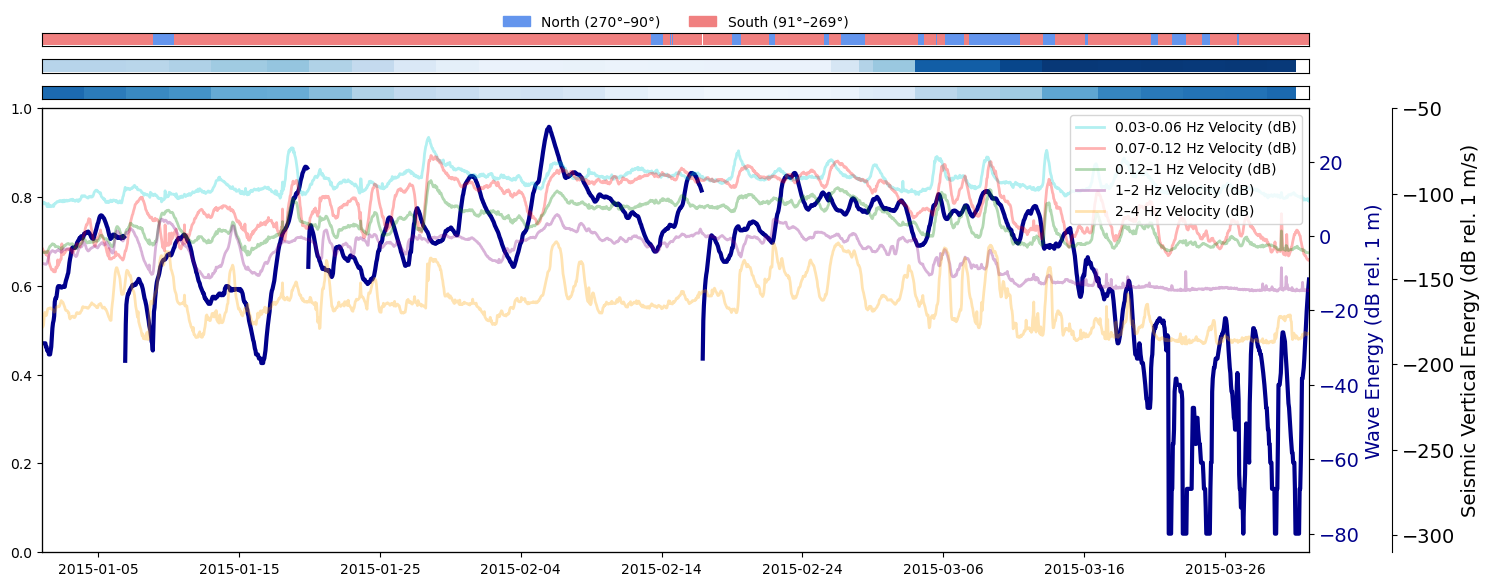

In [10]:
# add wave direction as colorstrip: 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Convert Significant Wave Height to energy in dB (10 * log10(H^2))
    wave_height = data['Thgt_m_med_hr'].copy()
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # First Right y-axis: Wave Energy in dB
    ax_right = ax.twinx()
    ax_right.plot(data['time_UTC2_num'], wave_energy_dB,
                  '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax_right.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    ax_right.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])

    # Second Right y-axis: Seismic Velocity Bands in dB
    ax_outer_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'darkturquoise'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'red'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'purple'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'orange'),
    }

    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_outer_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label} Velocity (dB)', 
            color=color,
            linewidth=2,
            alpha=0.3  # Adjust this value (0.0 to 1.0) for desired transparency
        )
    ax_outer_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_outer_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_outer_right.legend(loc='upper right', fontsize=10)
    ax_outer_right.set_ylim([-310, -50])
    ax_outer_right.spines['right'].set_position(('outward', 60))
    ax_outer_right.spines['right'].set_color('black')
    ax_outer_right.yaxis.set_label_position('right')
    ax_outer_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], [sea_ice_df_near, sea_ice_df_west], [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

    # Classify wave direction into north or south
    wave_dir = data['Tdir_deg_med_hr'].copy()
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
    
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'cornflowerblue'   # North
    binary_colors[south_mask] = 'lightcoral'    # South
    
    # Create new inset axis above the sea ice strips
    strip_ax_dir = ax.inset_axes([0, 1.14, 1, 0.03])  # Adjust y if needed
    
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    
    # Fill with binary color based on direction
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
    
    # Add custom legend instead of colorbar
    legend_patches = [
        mpatches.Patch(color='cornflowerblue', label='North (270°–90°)'),
        mpatches.Patch(color='lightcoral', label='South (91°–269°)')
    ]
    strip_ax_dir.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 1.8), ncol=2, fontsize=10, frameon=False)

plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('your_output_path.png', format='png', dpi=600, bbox_inches='tight')
plt.show()


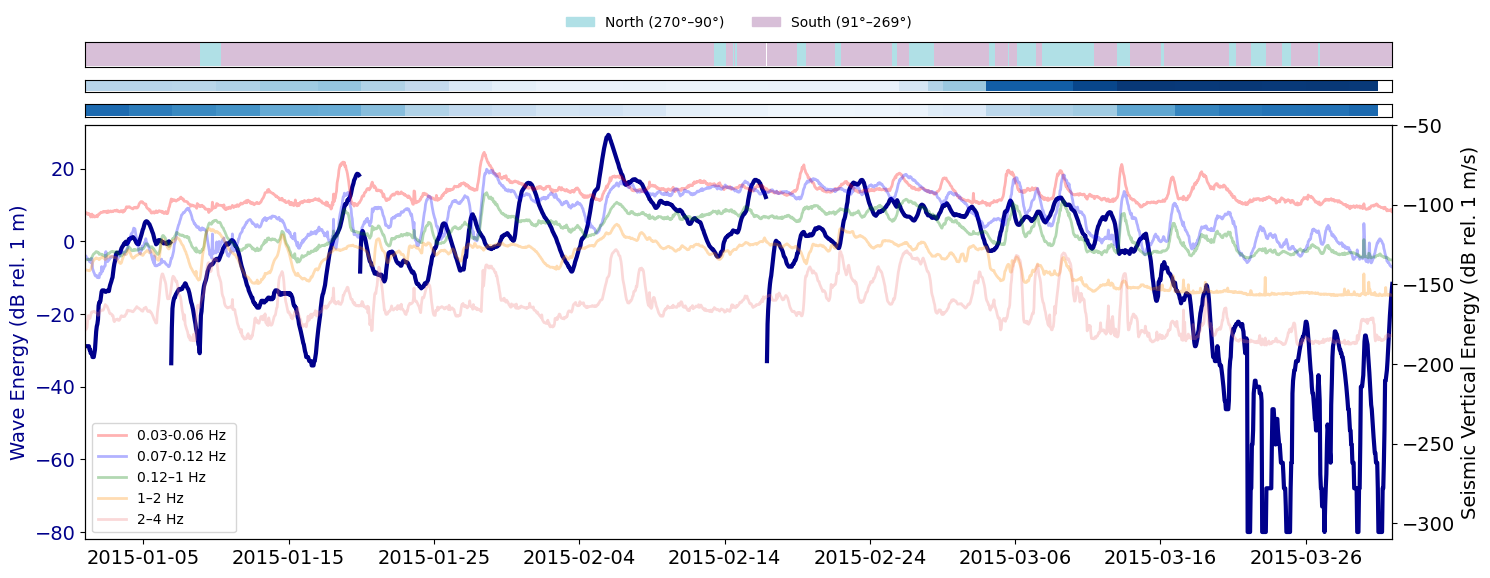

In [11]:
# change y-axis plotting and legend move

# add wave direction as colorstrip: 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = data['Thgt_m_med_hr'].copy()
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-82, 32])
    
    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'red'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'blue'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label} ', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_right.legend(loc='lower left', fontsize=10)
    ax_right.set_ylim([-310, -50])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')


    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], [sea_ice_df_near, sea_ice_df_west], [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

    # Classify wave direction into north or south
    wave_dir = data['Tdir_deg_med_hr'].copy()
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
    
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'powderblue'   # North
    binary_colors[south_mask] = 'thistle'    # South
    
    # Create new inset axis above the sea ice strips
    strip_ax_dir = ax.inset_axes([0, 1.14, 1, 0.06])  # Adjust y if needed
    
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    
    # Fill with binary color based on direction
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
    
    # Add custom legend instead of colorbar
    legend_patches = [
        mpatches.Patch(color='powderblue', label='North (270°–90°)'),
        mpatches.Patch(color='thistle', label='South (91°–269°)')
    ]
    strip_ax_dir.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 1.8), ncol=2, fontsize=10, frameon=False)

plt.xticks(rotation=45)
#plt.title('WW3 Nearshore Wave Height and DR01 Station Energy Band Comparison')
plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestCorridorWavesWW3_AllseimicPower.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

do this but with Offshore West Data (combine lon E w long W) 
West Offshore 1 (westernmost, E longitude): 
-67 to -72.5 latitude
173 to 179.5 longitude

West Offshore 2 (easternmost, E longitude): 
-67 to -72.5 latitude
-173 to-179.5 longitude

Each csv file produces 13 values for each lat/lon combination, equally representing each sector so that
when combined, they are equally weighted as a spatial median. 

downloading from WW3 site as usual, using Data_Prep_Waves+Station_Data_2025.ipynb for each spreadsheet as before. 
Combine the two as an average. 
use combined csv as main file.

then, convert all of the data prep and this code to use .nc files so you can compare the same plots but with different wave data for specific dates at first- WAVERY and CAWCR. Zoom into Storm dates and compare WW3, WAVERY and CAWCR swell to bands.

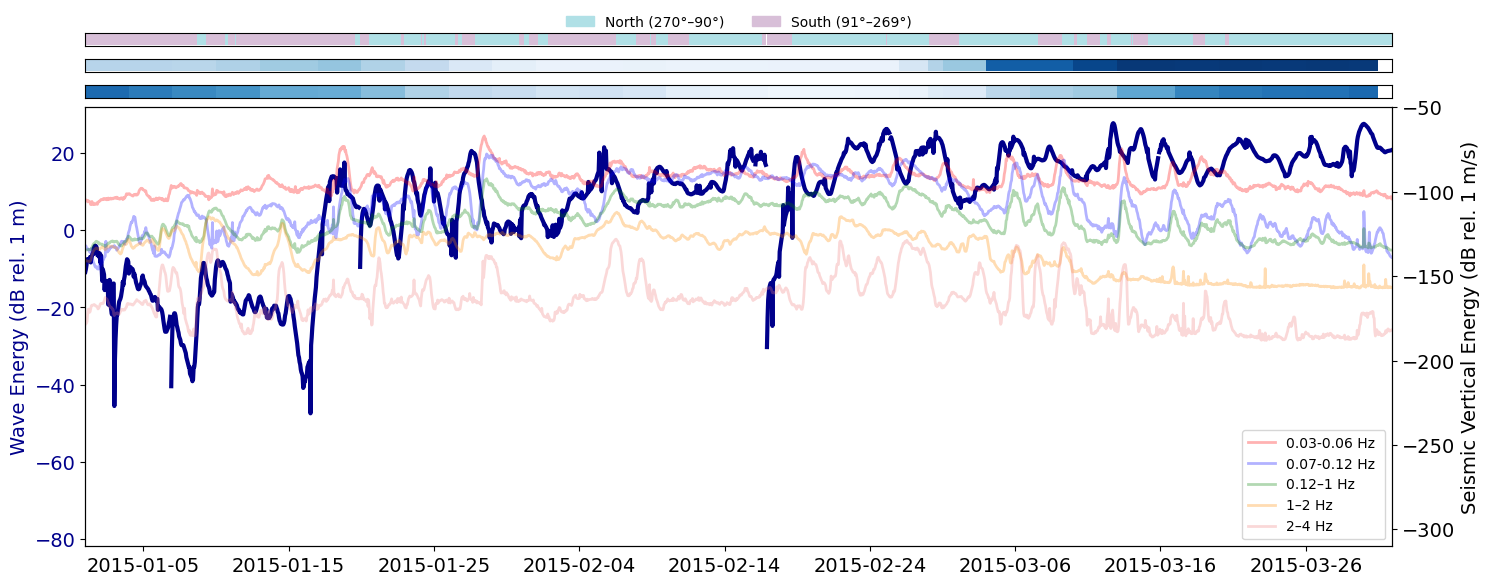

In [12]:
#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-82, 32])

    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'red'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'blue'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label} ', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_right.legend(loc='lower right', fontsize=10)
    ax_right.set_ylim([-310, -50])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')


    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], [sea_ice_df_near, sea_ice_df_west], [colors_near, colors_west]):
        strip_ax.set_xlim(ax.get_xlim())
        strip_ax.set_xticks([])
        strip_ax.set_yticks([])
        for i in range(len(df) - 1):
            if pd.isna(df['perc_non_black'].iloc[i]):
                continue
            strip_ax.fill_between(
                [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
                0, 1, color=colors[i], linewidth=0
            )

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'powderblue'   # North
    binary_colors[south_mask] = 'thistle'    # South
    
    # Create new inset axis above the sea ice strips
    strip_ax_dir = ax.inset_axes([0, 1.14, 1, 0.03])  # Adjust y if needed
    
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    
    # Fill with binary color based on direction
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
    
    # Add custom legend instead of colorbar
    legend_patches = [
        mpatches.Patch(color='powderblue', label='North (270°–90°)'),
        mpatches.Patch(color='thistle', label='South (91°–269°)')
    ]
    strip_ax_dir.legend(handles=legend_patches, loc='center', bbox_to_anchor=(0.5, 1.8), ncol=2, fontsize=10, frameon=False)

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestOffshoreWavesWW3_AllseimicPower.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# same as above but with another color stick - need to stack n/s on top of 4th color stick

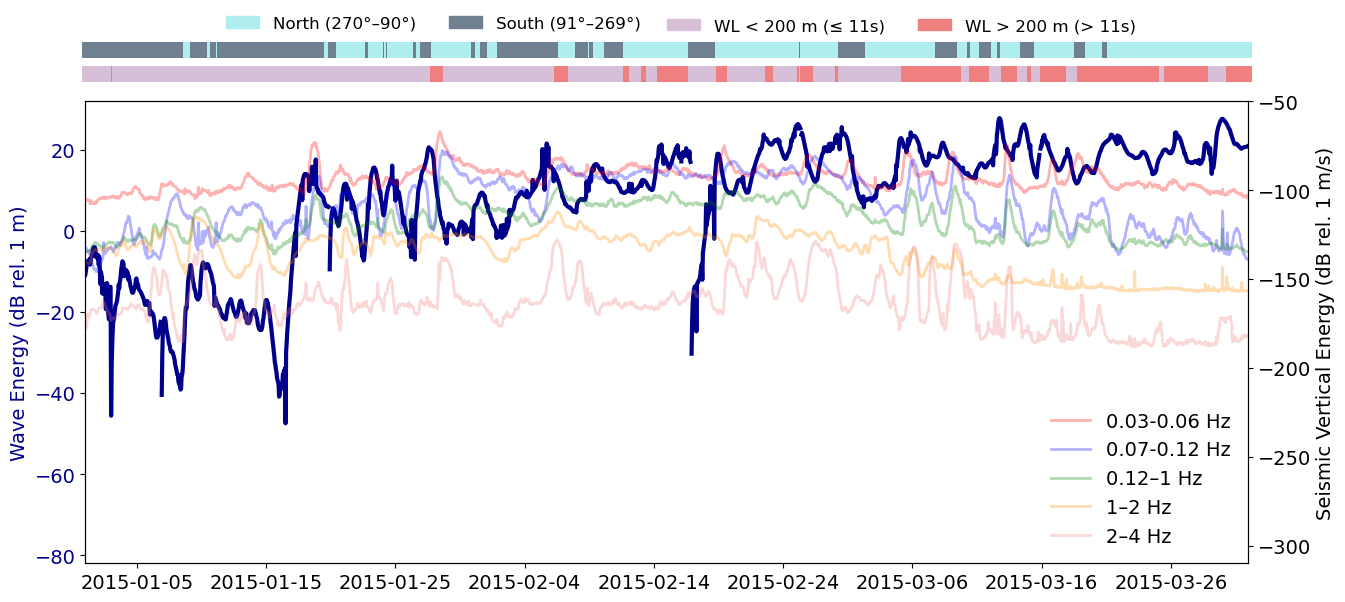

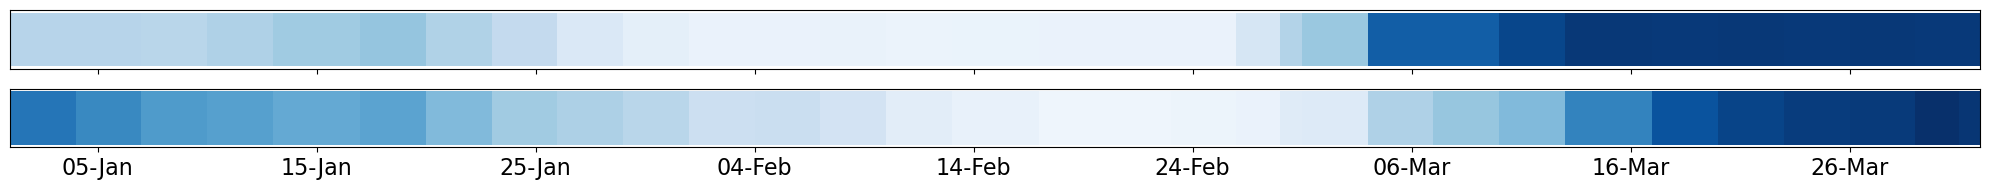

In [16]:
#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-82, 32])

    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'red'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'blue'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    # Plotting loop stays the same
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    # Add this after the loop to customize the legend
    #ax_right.legend(fontsize=16)  # Change 12 to your desired font size

    legend = ax_right.legend(loc='lower right', fontsize=14, frameon=False)
    
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax_right.legend(loc='lower right', fontsize=10)
    ax_right.set_ylim([-310, -50])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday_new.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-04-01 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South

    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
#~~~
    #strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    #strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])
    # Set common position parameters
    left = 0.123
    width = 0.78
    height = 0.03
    bottom_per = 0.91     # Period strip position
    bottom_dir = 0.95     # Direction strip position (above period)
    
    # Add wave period strip
    strip_ax_per = fig.add_axes([left, bottom_per, width, height])
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    strip_ax_per.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )
    
    # Add wave direction strip ABOVE the period strip
    strip_ax_dir = fig.add_axes([left, bottom_dir, width, height])
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    strip_ax_dir.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
#~~

    import matplotlib.patches as mpatches
    
    # Update these to match the new color assignments
    legend_patches = [
        mpatches.Patch(color='paleturquoise', label='North (270°–90°)'),
        mpatches.Patch(color='slategrey', label='South (91°–269°)')
    ]

    legend_patches_period = [
        mpatches.Patch(color='thistle', label='WL < 200 m (≤ 11s)'),
        mpatches.Patch(color='lightcoral', label='WL > 200 m (> 11s)')
    ]

    strip_ax_dir.legend(
        handles=legend_patches,
        loc='center',
        bbox_to_anchor=(0.3, 2.0),
        ncol=2,
        fontsize=12,
        frameon=False
    )
    
    strip_ax_per.legend(
        handles=legend_patches_period,
        loc='center',
        bbox_to_anchor=(0.7, 3.2),
        ncol=2,
        fontsize=12,
        frameon=False
    )

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
#plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestOffshoreWavesWW3_AllseimicPower2.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

# Create a new figure for the sea ice color strips
fig2, (ax_ice_near, ax_ice_west) = plt.subplots(nrows=2, sharex=True, figsize=(20, 2))  # Taller axes

# Normalize and colormap settings (can be reused)
norm = mcolors.Normalize(vmin=0, vmax=100)
cmap = cm.Blues
colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

# Plot near shelf sea ice
ax_ice_near.set_xlim(ax.get_xlim())
ax_ice_near.set_yticks([])
# ax_ice_near.set_ylabel('Near Shelf', fontsize=12)
for i in range(len(sea_ice_df_near) - 1):
    if pd.isna(sea_ice_df_near['perc_non_black'].iloc[i]):
        continue
    ax_ice_near.fill_between(
        [sea_ice_df_near['time_num'].iloc[i], sea_ice_df_near['time_num'].iloc[i + 1]],
        0, 1, color=colors_near[i], linewidth=0
    )

# Plot west corridor sea ice
ax_ice_west.set_xlim(ax.get_xlim())
ax_ice_west.set_yticks([])
# ax_ice_west.set_ylabel('West Corridor', fontsize=12)
ax_ice_west.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))

for i in range(len(sea_ice_df_west) - 1):
    if pd.isna(sea_ice_df_west['perc_non_black'].iloc[i]):
        continue
    ax_ice_west.fill_between(
        [sea_ice_df_west['time_num'].iloc[i], sea_ice_df_west['time_num'].iloc[i + 1]],
        0, 1, color=colors_west[i], linewidth=0
    )

# Tidy up
plt.setp(ax_ice_west.get_xticklabels(), rotation=0, ha='center', fontsize=16)
fig2.tight_layout()
# fig2.savefig('/Users/em/PROJECTS/SeaIce/FIGS/DR01SeaIceStrips_West.png', format='png', dpi=600, bbox_inches='tight')
# plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01SeaIceStrips_West.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

In [5]:
# in-line with code above, (run it first), SEA ICE STRIPS

    # Create a new figure for the sea ice color strips
    fig2, (ax_ice_near, ax_ice_west) = plt.subplots(nrows=2, sharex=True, figsize=(20, 2))  # Taller axes
    
    # Normalize and colormap settings (can be reused)
    norm = mcolors.Normalize(vmin=0, vmax=100)
    cmap = cm.Blues
    colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))
    
    # Plot near shelf sea ice
    ax_ice_near.set_xlim(ax.get_xlim())
    ax_ice_near.set_yticks([])
    #ax_ice_near.set_ylabel('Near Shelf', fontsize=12)
    for i in range(len(sea_ice_df_near) - 1):
        if pd.isna(sea_ice_df_near['perc_non_black'].iloc[i]):
            continue
        ax_ice_near.fill_between(
            [sea_ice_df_near['time_num'].iloc[i], sea_ice_df_near['time_num'].iloc[i + 1]],
            0, 1, color=colors_near[i], linewidth=0
        )
    
    # Plot west corridor sea ice
    ax_ice_west.set_xlim(ax.get_xlim())
    ax_ice_west.set_yticks([])
    #ax_ice_west.set_ylabel('West Corridor', fontsize=12)
    ax_ice_west.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    
    for i in range(len(sea_ice_df_west) - 1):
        if pd.isna(sea_ice_df_west['perc_non_black'].iloc[i]):
            continue
        ax_ice_west.fill_between(
            [sea_ice_df_west['time_num'].iloc[i], sea_ice_df_west['time_num'].iloc[i + 1]],
            0, 1, color=colors_west[i], linewidth=0
        )

# Tidy up
plt.setp(ax_ice_west.get_xticklabels(), rotation=0, ha='center', fontsize=16)
fig2.tight_layout()
#fig2.savefig('/Users/em/PROJECTS/SeaIce/FIGS/DR01SeaIceStrips_West.png', format='png', dpi=600, bbox_inches='tight')
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01SeaIceStrips_West.png', format='png', dpi=600, bbox_inches='tight')

plt.show()

IndentationError: unexpected indent (4248989288.py, line 4)

/var/folders/n_/3zw40qc51xd2r3ngkqw0116h0000gn/T/ipykernel_7887/849811612.py:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


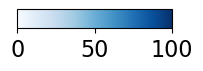

In [4]:
# create sea ice strip colorbar

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Set up colormap and normalization (match your main plot)
cmap = cm.Blues
norm = mcolors.Normalize(vmin=0, vmax=100)  # sea ice percentage range

# Create a new figure for the colorbar
fig, ax = plt.subplots(figsize=(2, .25))  # wide and short

# Create a colorbar only
cb = plt.colorbar(
    cm.ScalarMappable(norm=norm, cmap=cmap),
    cax=ax,
    orientation='horizontal'
)

#cb.set_label('Sea Ice, Percent of Corridor with SIC > 25%', fontsize=12)
cb.ax.tick_params(labelsize=16)

plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/SeaIce/FIGS/DR01SeaIceStrips_West_Cbar_h.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

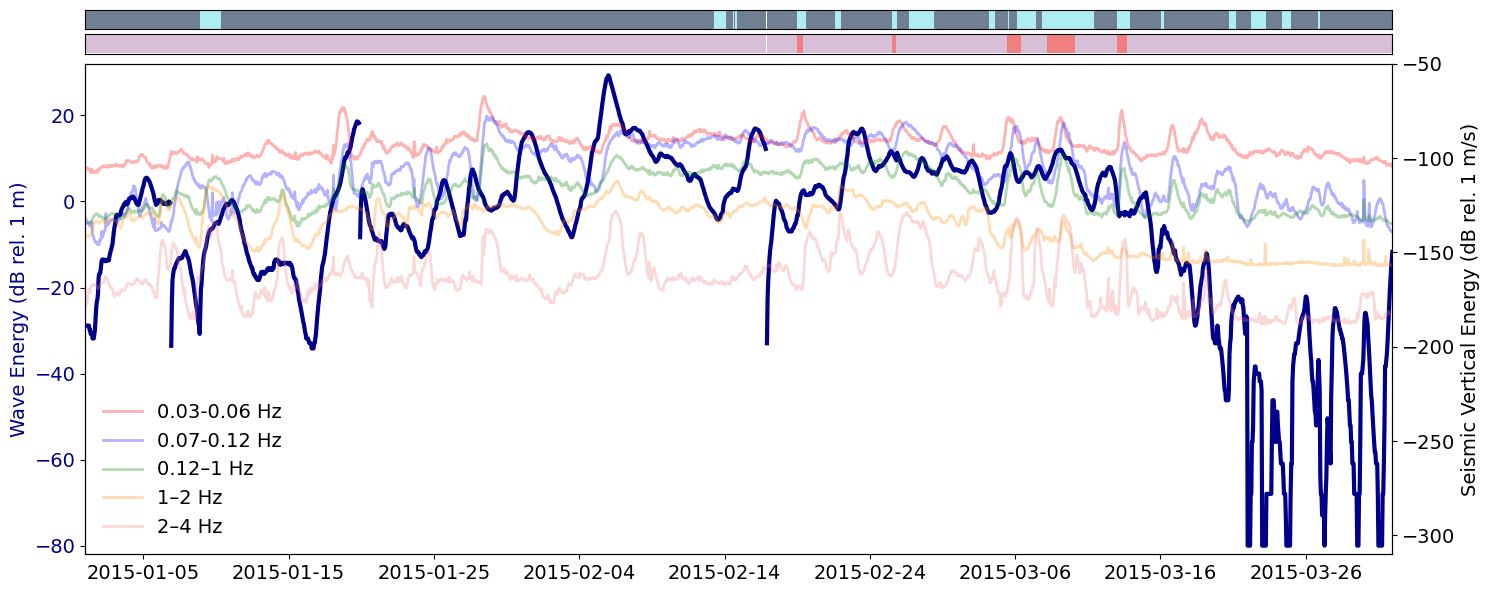

In [124]:
# change y-axis plotting and legend move

# add wave direction as colorstrip: 

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = data['Thgt_m_med_hr'].copy()
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-82, 32])
    
    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'red'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'blue'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label} ', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax_right.legend(loc='lower left', fontsize=10)
    legend = ax_right.legend(loc='lower left', fontsize=14, frameon=False)
    ax_right.set_ylim([-310, -50])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    #ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    #ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    #sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    #sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    #start_date = pd.Timestamp('2015-01-01', tz='UTC')
    #end_date = pd.Timestamp('2015-03-31 00:00:00', tz='UTC')
    #sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    #sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    #sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    #sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    #norm = mcolors.Normalize(vmin=0, vmax=100)
    #cmap = cm.Blues
    #colors_near = cmap(norm(sea_ice_df_near['perc_non_black'].values))
    #colors_west = cmap(norm(sea_ice_df_west['perc_non_black'].values))

    #strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    #strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])

    #for strip_ax, df, colors in zip([strip_ax_near, strip_ax_west], [sea_ice_df_near, sea_ice_df_west], [colors_near, colors_west]):
    #    strip_ax.set_xlim(ax.get_xlim())
    #    strip_ax.set_xticks([])
    #    strip_ax.set_yticks([])
    #    for i in range(len(df) - 1):
    #        if pd.isna(df['perc_non_black'].iloc[i]):
    #            continue
    #        strip_ax.fill_between(
    #            [df['time_num'].iloc[i], df['time_num'].iloc[i + 1]],
    #            0, 1, color=colors[i], linewidth=0
    #        )

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South
    
    strip_ax_dir = ax.inset_axes([0, 1.07, 1, 0.04])  # Adjust y if needed
    
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    
    # Fill with binary color based on direction
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
    
    # Custom legend for wave direction
    #legend_patches = [
    #    mpatches.Patch(color='lightcoral', label='North (270°–90°)'),
    #    mpatches.Patch(color='thistle', label='South (91°–269°)')
    #]
    #strip_ax_dir.legend(
    #    handles=legend_patches,
    #    loc='center',
    #    bbox_to_anchor=(0.65, 4.75),  # dir: (0.65, 4.75); per: (0.3, 2.75)
    #    ncol=2,
    #    fontsize=12,
    #    frameon=False
    #)

    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
    strip_ax_per = ax.inset_axes([0, 1.02, 1, 0.04])  # goes above wave direction # [left, bottom, width, height]
        
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    
    # Fill with period color
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )

    # Custom legend for wave period
    #legend_patches_period = [
    #    mpatches.Patch(color='slategray', label='WL < 200 m (0–11 s)'),
    #    #mpatches.Patch(color='turquoise', label='Mid (10–16 s)'),
    #    mpatches.Patch(color='paleturquoise', label='WL > 200 m (11–22 s)')
    #]
    #strip_ax_per.legend(
    #    handles=legend_patches_period,
    #    loc='center',
    #    bbox_to_anchor=(0.3, 2.75),  # Adjusted to align with the wave direction legend
    #    ncol=3,
    #    fontsize=12,
    #    frameon=False
    #)

plt.xticks(rotation=45)
#plt.title('WW3 Nearshore Wave Height and DR01 Station Energy Band Comparison')
plt.tight_layout()
plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestCorridorWavesWW3_AllseimicPower_noSIC2.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
#

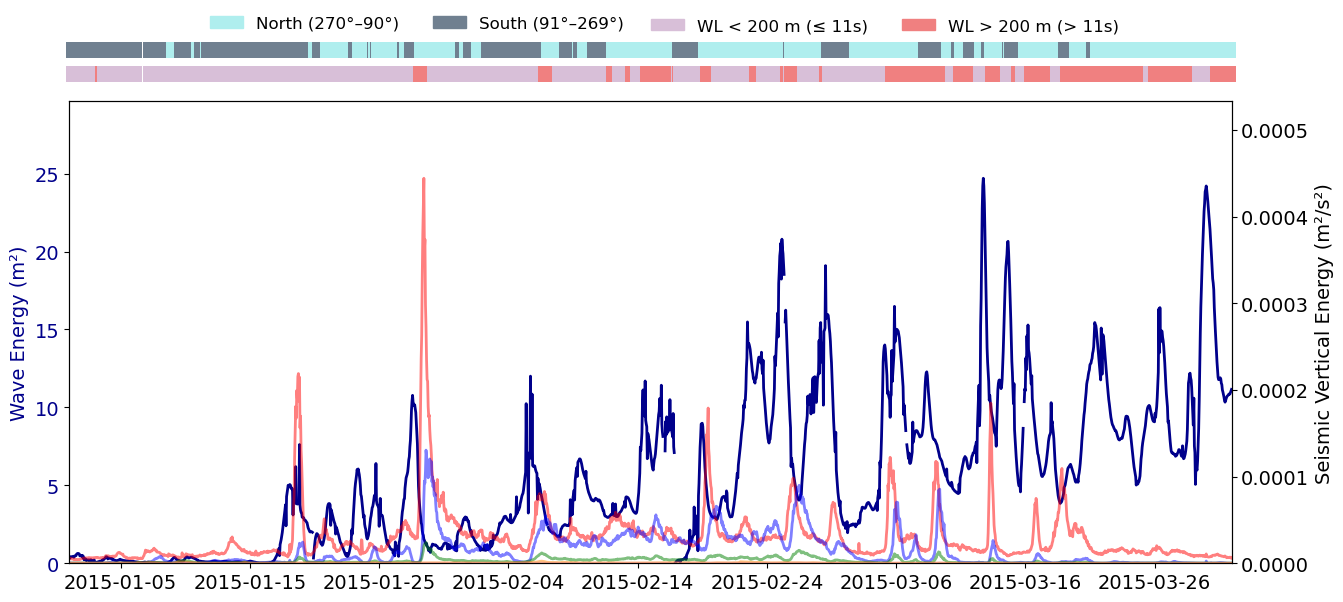

In [8]:
# Offshore but not dB
#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy (squared, not dB)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    
    ax.plot(data['time_UTC2_num'], wave_energy,
            '-', color='darkblue', linewidth=2, label="Wave Energy (m²)")
    ax.set_ylabel('Wave Energy (m²)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    # Set reasonable wave energy y-limits (auto or manual)
    ax.set_ylim([0, np.nanmax(wave_energy) * 1.2])

    # Right y-axis: Seismic Velocity Bands (linear, not dB)
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz', 'red'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz', 'blue'),
        'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    for column, (label, color) in bands.items():
        velocity = pd.to_numeric(data[column], errors='coerce')
        velocity[velocity <= 0] = np.nan  # optional: skip negatives
        ax_right.plot(
            data['time_UTC2_num'],
            velocity,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.5
        )
    
    #legend = ax_right.legend(loc='lower right', fontsize=14, frameon=False)
    
    ax_right.set_ylabel('Seismic Vertical Energy (m²/s²)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_right.set_ylim([0, np.nanmax(data[list(bands.keys())].values.flatten()) * 1.2])
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-04-01 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South

    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
#~~~
    #strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    #strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])
    # Set common position parameters
    left = 0.123
    width = 0.78
    height = 0.03
    bottom_per = 0.91     # Period strip position
    bottom_dir = 0.95     # Direction strip position (above period)
    
    # Add wave period strip
    strip_ax_per = fig.add_axes([left, bottom_per, width, height])
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    strip_ax_per.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )
    
    # Add wave direction strip ABOVE the period strip
    strip_ax_dir = fig.add_axes([left, bottom_dir, width, height])
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    strip_ax_dir.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
#~~

    import matplotlib.patches as mpatches
    
    # Update these to match the new color assignments
    legend_patches = [
        mpatches.Patch(color='paleturquoise', label='North (270°–90°)'),
        mpatches.Patch(color='slategrey', label='South (91°–269°)')
    ]

    legend_patches_period = [
        mpatches.Patch(color='thistle', label='WL < 200 m (≤ 11s)'),
        mpatches.Patch(color='lightcoral', label='WL > 200 m (> 11s)')
    ]

    strip_ax_dir.legend(
        handles=legend_patches,
        loc='center',
        bbox_to_anchor=(0.3, 2.0),
        ncol=2,
        fontsize=12,
        frameon=False
    )
    
    strip_ax_per.legend(
        handles=legend_patches_period,
        loc='center',
        bbox_to_anchor=(0.7, 3.2),
        ncol=2,
        fontsize=12,
        frameon=False
    )

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
#plt.tight_layout()
plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestOffshoreWavesWW3_AllseimicPower2_linear.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

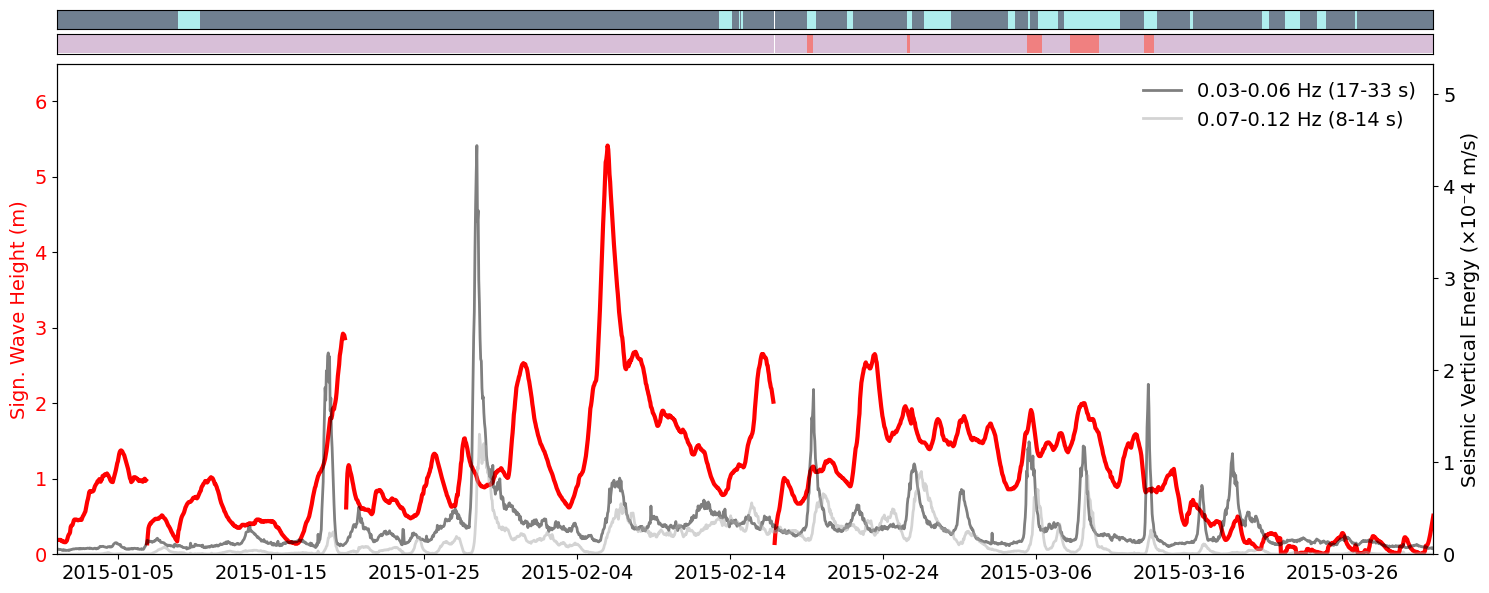

In [52]:
# nearshore but not in dB

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'
]
locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

#file_paths = [
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv'
#]
#locations = ["2015 \n West Sector WaveWatch III \n & Station DR01"]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Left y-axis: Wave Energy (squared, not dB)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height #** 2
    wave_energy[wave_energy <= 0] = np.nan
    
    ax.plot(data['time_UTC2_num'], wave_energy,
            '-', color='red', linewidth=3, label="Sign. Wave Height (m)")
    ax.set_ylabel('Sign. Wave Height (m)', color='red', fontsize=14)
    ax.tick_params(axis='y', labelcolor='red', labelsize=14)
    # Set reasonable wave energy y-limits (auto or manual)
    ax.set_ylim([0, np.nanmax(wave_energy) * 1.2])

    # Right y-axis: Seismic Velocity Bands (linear, not dB)
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'black'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'darkgray'),
        #'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        #'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        #'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    for column, (label, color) in bands.items():
        velocity = pd.to_numeric(data[column], errors='coerce')
        velocity[velocity <= 0] = np.nan  # optional: skip negatives
        ax_right.plot(
            data['time_UTC2_num'],
            velocity,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.5
        )
    
    legend = ax_right.legend(loc='upper right', fontsize=14, frameon=False)

    #~~ ADDED SCI NOTATION FOR Y-AXIS HERE
    import matplotlib.ticker as ticker
    
    # Determine scale factor (e.g., 1e-7) based on your data
    scale_factor = 1e-4
    ax_right.set_ylabel('Seismic Vertical Energy (×10⁻4 m/s)', color='black', fontsize=14)
    
    # Apply scaling to your y data before plotting or set a FuncFormatter
    formatter = ticker.FuncFormatter(lambda x, _: f'{x / scale_factor:.0f}')
    ax_right.yaxis.set_major_formatter(formatter)
    
    # The rest of your axis settings
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_right.set_ylim([0, np.nanmax(data[list(bands.keys())].values.flatten()) * 1.2])
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')

    #~~ END UPDATE TO SCI NOTATION

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South
    
    strip_ax_dir = ax.inset_axes([0, 1.07, 1, 0.04])  # Adjust y if needed
    
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    
    # Fill with binary color based on direction
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
    
    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
    strip_ax_per = ax.inset_axes([0, 1.02, 1, 0.04])  # goes above wave direction # [left, bottom, width, height]
        
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    
    # Fill with period color
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )

plt.xticks(rotation=45)
#plt.title('WW3 Nearshore Wave Height and DR01 Station Energy Band Comparison')
plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WestCorridorWavesWW3_AllseimicPower_noSIC2_linear.png', format='png', dpi=600, bbox_inches='tight')
plt.show()#

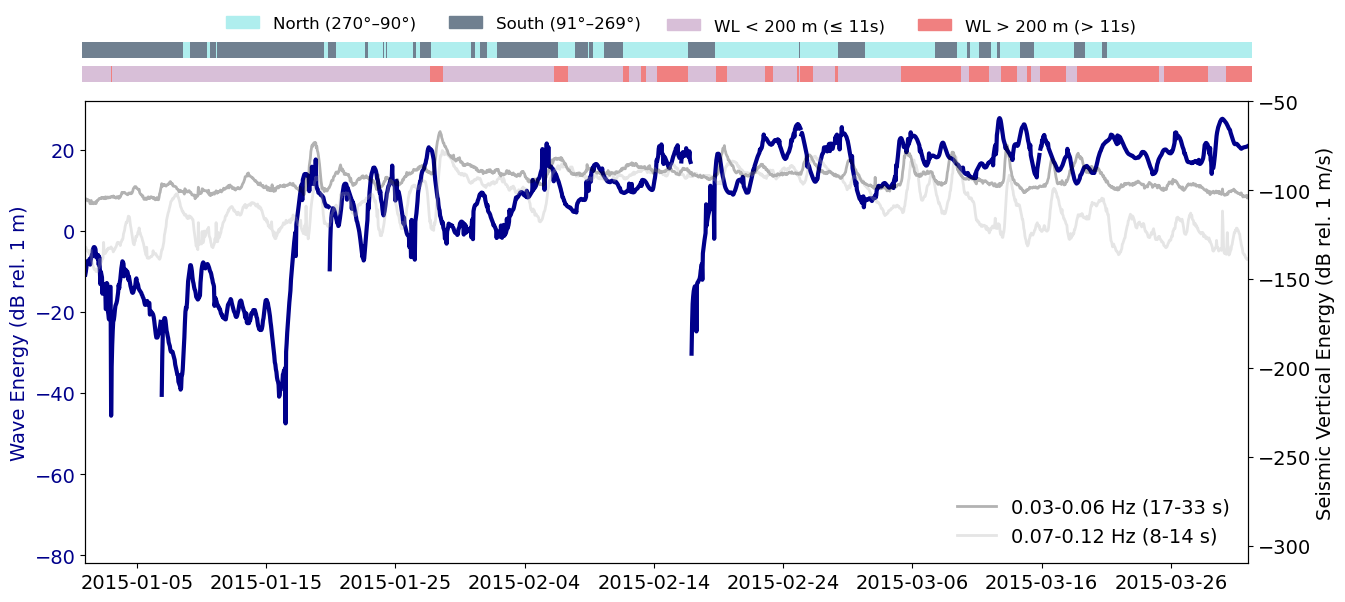

In [14]:
# combine offshore and ross sea waves into one plot, remove colorsticks

#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv' #Northwest sector, offshore
]
#file_paths = [
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv' #Ross Sea west sector
#]

fig, ax = plt.subplots(figsize=(15, 6))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=3, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-82, 32])

    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'black'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'darkgray'),
        #'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        #'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        #'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    # Plotting loop stays the same
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    # Add this after the loop to customize the legend
    #ax_right.legend(fontsize=16)  # Change 12 to your desired font size

    legend = ax_right.legend(loc='lower right', fontsize=14, frameon=False)
    
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax_right.legend(loc='lower right', fontsize=10)
    ax_right.set_ylim([-310, -50])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')

    # Set x-axis limits and formatting
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-04-01 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South

    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
#~~~
    #strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    #strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])
    # Set common position parameters
    left = 0.123
    width = 0.78
    height = 0.03
    bottom_per = 0.91     # Period strip position
    bottom_dir = 0.95     # Direction strip position (above period)
    
    # Add wave period strip
    strip_ax_per = fig.add_axes([left, bottom_per, width, height])
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    strip_ax_per.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )
    
    # Add wave direction strip ABOVE the period strip
    strip_ax_dir = fig.add_axes([left, bottom_dir, width, height])
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    strip_ax_dir.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
#~~

    import matplotlib.patches as mpatches
    
    # Update these to match the new color assignments
    legend_patches = [
        mpatches.Patch(color='paleturquoise', label='North (270°–90°)'),
        mpatches.Patch(color='slategrey', label='South (91°–269°)')
    ]

    legend_patches_period = [
        mpatches.Patch(color='thistle', label='WL < 200 m (≤ 11s)'),
        mpatches.Patch(color='lightcoral', label='WL > 200 m (> 11s)')
    ]

    strip_ax_dir.legend(
        handles=legend_patches,
        loc='center',
        bbox_to_anchor=(0.3, 2.0),
        ncol=2,
        fontsize=12,
        frameon=False
    )
    
    strip_ax_per.legend(
        handles=legend_patches_period,
        loc='center',
        bbox_to_anchor=(0.7, 3.2),
        ncol=2,
        fontsize=12,
        frameon=False
    )

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
#plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01eWavesWW3_SwellPower_BOTH.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

/var/folders/n_/3zw40qc51xd2r3ngkqw0116h0000gn/T/ipykernel_84923/3916896342.py:74: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax_right.legend(loc='lower right', fontsize=12, frameon=False)


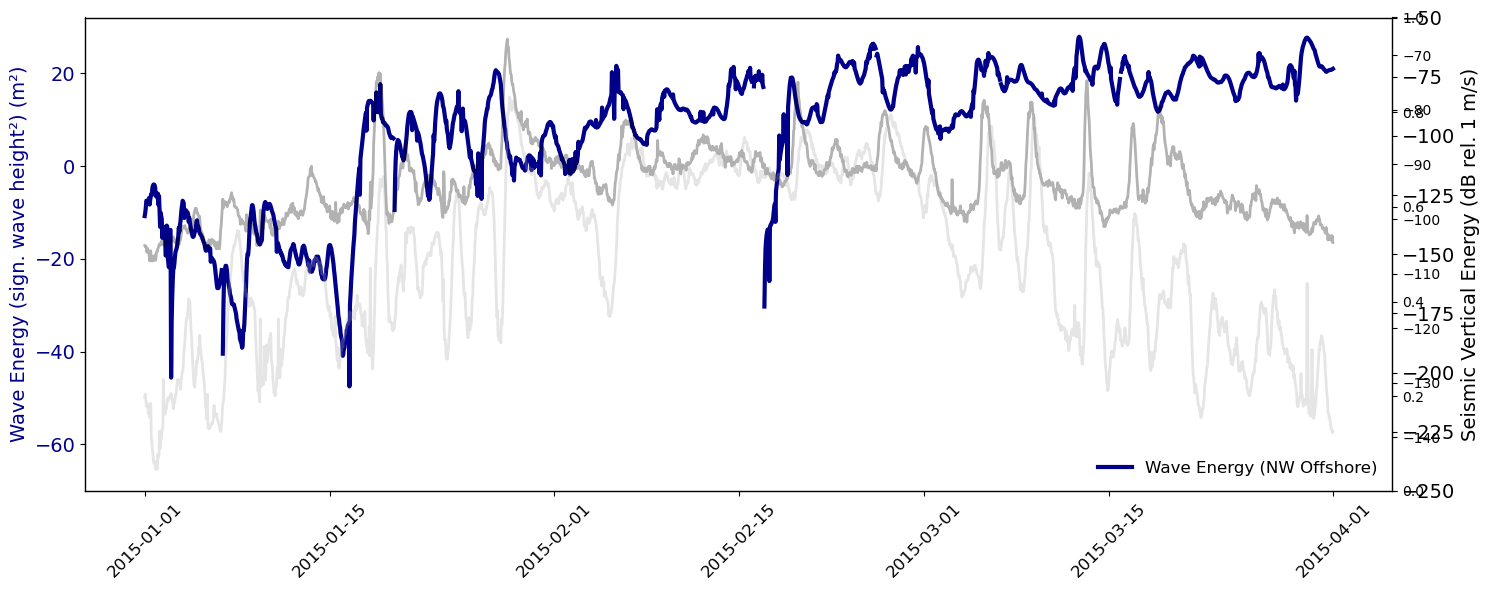

In [30]:
# File paths for both sectors
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv',  # Northwest sector (offshore)
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'        # Ross Sea west sector
]

# Line colors for each data source
line_colors = ['darkblue', 'cadetblue']
line_labels = ['NW Offshore', 'Ross Sea West']

fig, ax = plt.subplots(figsize=(15, 6))

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Wave energy computation
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color=line_colors[i], linewidth=3, label=f"Wave Energy ({line_labels[i]})")

    # Only plot seismic once, from the first dataset
    if i == 0:
        ax_right = ax.twinx()
        ax_left = ax.twinx()
        bands = {
            'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'black'), 
            'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'darkgray'),
        }

        for column, (label, color) in bands.items():
            velocity = data[column].copy()
            velocity[velocity <= 0] = np.nan
            velocity_dB = 20 * np.log10(velocity)
            ax_right.plot(
                data['time_UTC2_num'],
                velocity_dB,
                '-', 
                label=label, 
                color=color,
                linewidth=2,
                alpha=0.3
            )

    import matplotlib.dates as mdates
    
    # LEFT Y-AXIS (Wave Energy)
    ax.set_ylabel('Wave Energy (sign. wave height²) (m²)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    ax.set_ylim([-70, 32])
    ax.yaxis.set_label_position('left')
    ax.yaxis.set_ticks_position('left')
    
    # RIGHT Y-AXIS (Seismic Energy)
    ax_right = ax.twinx()  # make sure this is defined once
    ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    ax_right.set_ylim([-250, -50])
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')
    
    # X-AXIS (Date Formatting)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.tick_params(axis='x', labelrotation=45, labelsize=12)

# Legends
ax.legend(loc='lower right', fontsize=12, frameon=False)
ax_right.legend(loc='lower right', fontsize=12, frameon=False)

plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


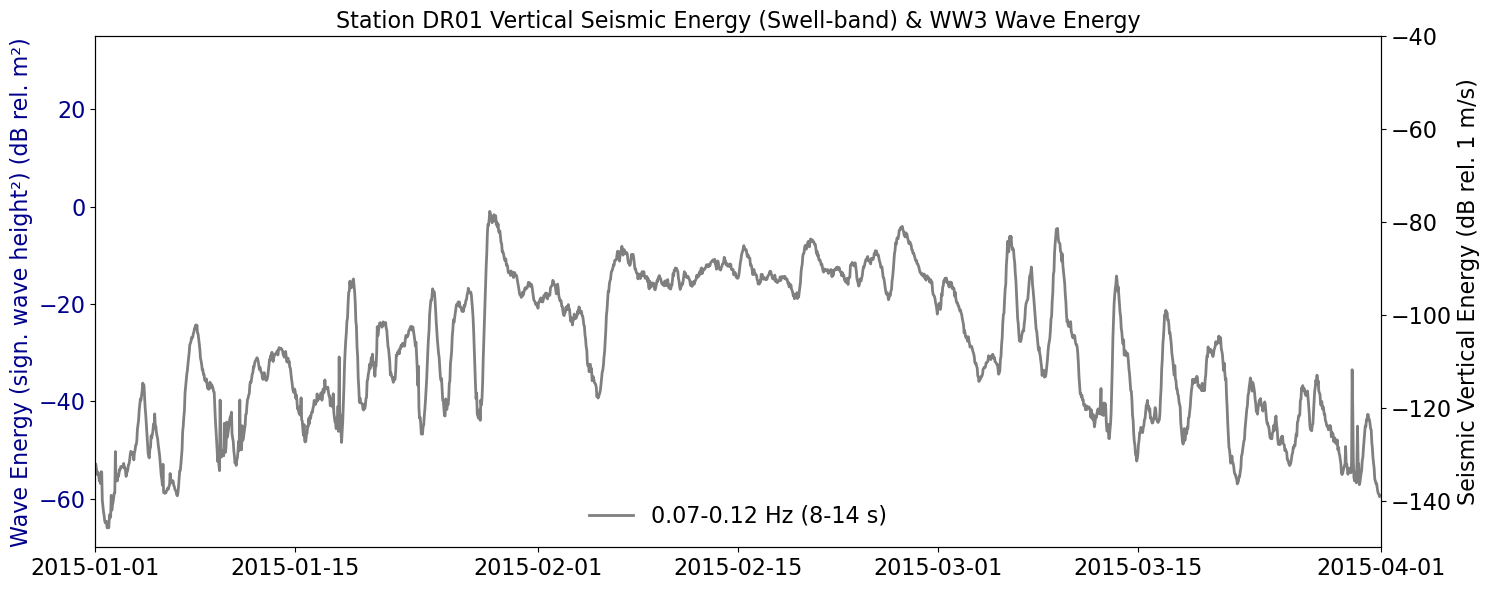

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# File paths for both sectors (only NW Offshore used)
#file_paths = [
#     '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv',  # Northwest sector (offshore)
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv'        # Ross Sea west sector
#]

# Line colors for each data source
line_colors = ['darkblue', 'powderblue'] #for NW Offslope, or BOTH
#line_colors = ['powderblue','darkblue'] #for Ross Sea only
line_labels = ['NW Offslope (67-72°S)', 'W Ross Sea (72-76°S)'] #for NW Offslope, or BOTH
#line_labels = ['W Ross Sea (72-76°S)', 'NW Offslope (67-72°S)'] #for Ross Sea only

# Create figure and primary axis
fig, ax = plt.subplots(figsize=(15, 6))
ax_right = ax.twinx()  # Right y-axis for seismic energy

# Loop through files (only one used here)
for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # --- Wave Energy ---
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)

#    ax.plot(
#        data['time_UTC2_num'], wave_energy_dB,
#        '-', color=line_colors[i], linewidth=3,
#        label=f"Wave Energy ({line_labels[i]})"
#    )

    # --- Seismic Energy (only once) ---
    bands = {
#        'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'darkgray'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'black'),
    }

    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity[velocity <= 0] = np.nan 
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', label=label, color=color,
            linewidth=2, alpha=0.5
        )

# --- Y-Axis Styling ---

# LEFT Y-AXIS (Wave Energy)
ax.set_ylabel('Wave Energy (sign. wave height²) (dB rel. m²)', color='darkblue', fontsize=16)
ax.tick_params(axis='y', labelcolor='darkblue', labelsize=16)
ax.set_ylim([-70, 35])
ax.yaxis.set_label_position('left')
ax.yaxis.set_ticks_position('left')

# RIGHT Y-AXIS (Seismic Energy)
ax_right.set_ylabel('Seismic Vertical Energy (dB rel. 1 m/s)', color='black', fontsize=16)
ax_right.tick_params(axis='y', labelcolor='black', labelsize=16)
ax_right.set_ylim([-150, -40])
ax_right.yaxis.set_label_position('right')
ax_right.yaxis.set_ticks_position('right')

from datetime import datetime

# Combine legends from both axes
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_right.get_legend_handles_labels()
ax.legend(handles1 + handles2, labels1 + labels2, loc='lower center', fontsize=16, frameon=False)

import pandas as pd
from datetime import datetime, timedelta

# Set x-axis limits from 1 Jan to 31 Mar 2015, inclusive
start_date = pd.Timestamp('2015-01-01')
end_date = pd.Timestamp('2015-03-31') + timedelta(days=1)  # Add 1 day to ensure visibility
ax.set_xlim([start_date, end_date])
ax.tick_params(axis='x', labelcolor='black', labelsize=16)

label2='Station DR01 Vertical Seismic Energy (Swell-band) & WW3 Wave Energy'
plt.title(label2, fontdict=None, loc='center', pad=None, fontsize=16)

plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01WavesWW3_NoSwell_YesSeismicShort_dB_r.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

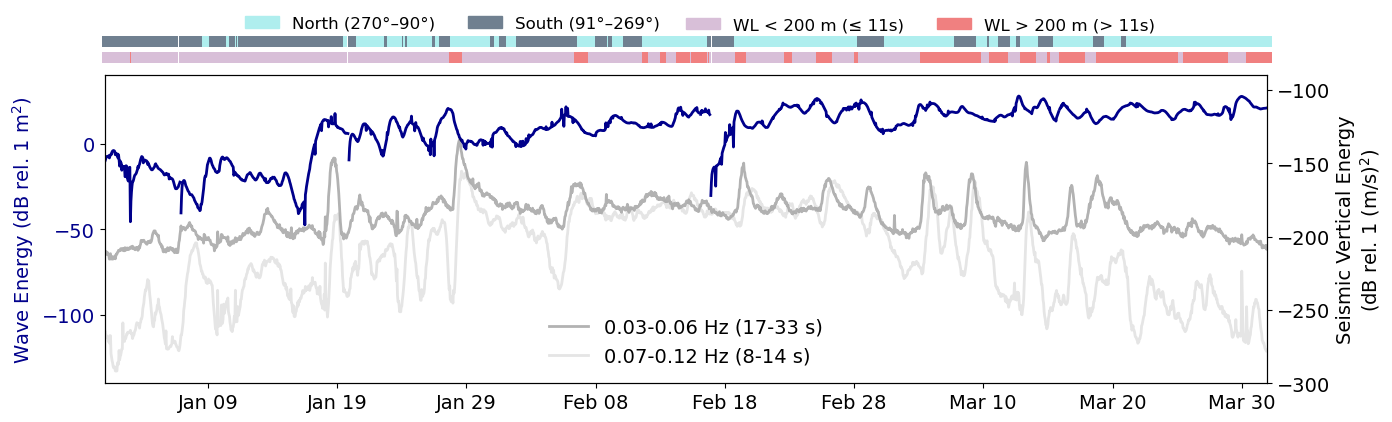

In [24]:
# combine offshore and ross sea waves into one plot, remove colorsticks

#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv' #Northwest sector, offshore
]
#file_paths = [
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv' #Ross Sea west sector
#]

fig, ax = plt.subplots(figsize=(15, 4))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=2, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m$^2$)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-140, 40])

    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'black'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'darkgray'),
        #'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        #'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        #'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    # Plotting loop stays the same
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity = velocity ** 2
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    # Add this after the loop to customize the legend
    #ax_right.legend(fontsize=16)  # Change 12 to your desired font size

    legend = ax_right.legend(loc='lower center', fontsize=14, frameon=False) #lower right
    
    ax_right.set_ylabel('Seismic Vertical Energy\n(dB rel. 1 (m/s)$^2$)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax_right.legend(loc='lower right', fontsize=10)
    ax_right.set_ylim([-300, -90])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')
    
    # Set x-axis limits
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-04-01 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

    # Classify wave direction into north or south
    wave_dir = pd.to_numeric(data['Tdir_deg_med_hr'], errors='coerce')
    north_mask = (wave_dir <= 90) | (wave_dir >= 270)
    south_mask = (wave_dir > 90) & (wave_dir < 270)
        
    # Assign colors
    binary_colors = np.full(len(wave_dir), np.nan, dtype=object)
    binary_colors[north_mask] = 'paleturquoise'   # North
    binary_colors[south_mask] = 'slategrey'    # South

    # Classify wave period into low, mid, high
    wave_per = pd.to_numeric(data['Tper_s_med_hr'], errors='coerce')
    
    lo_mask = (wave_per > 0) & (wave_per <= 11)
    #mid_mask = (wave_per > 10) & (wave_per <= 16)
    hi_mask = (wave_per > 11) & (wave_per <= 22)
    
    # Assign colors
    period_colors = np.full(len(wave_per), np.nan, dtype=object)
    period_colors[lo_mask] = 'thistle'       # Low
    #period_colors[mid_mask] = 'turquoise'    # Mid
    period_colors[hi_mask] = 'lightcoral'    # High
    
#~~~
    #strip_ax_near = ax.inset_axes([0, 1.08, 1, 0.03])
    #strip_ax_west = ax.inset_axes([0, 1.02, 1, 0.03])
    # Set common position parameters
    left = 0.123
    width = 0.78
    height = 0.03
    bottom_per = 0.91     # Period strip position
    bottom_dir = 0.95     # Direction strip position (above period)
    
    # Add wave period strip
    strip_ax_per = fig.add_axes([left, bottom_per, width, height])
    strip_ax_per.set_xlim(ax.get_xlim())
    strip_ax_per.set_xticks([])
    strip_ax_per.set_yticks([])
    strip_ax_per.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(period_colors[i]):
            continue
        strip_ax_per.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=period_colors[i], linewidth=0
        )
    
    # Add wave direction strip ABOVE the period strip
    strip_ax_dir = fig.add_axes([left, bottom_dir, width, height])
    strip_ax_dir.set_xlim(ax.get_xlim())
    strip_ax_dir.set_xticks([])
    strip_ax_dir.set_yticks([])
    strip_ax_dir.set_frame_on(False)
    
    for i in range(len(data) - 1):
        if pd.isna(binary_colors[i]):
            continue
        strip_ax_dir.fill_between(
            [data['time_UTC2_num'].iloc[i], data['time_UTC2_num'].iloc[i + 1]],
            0, 1, color=binary_colors[i], linewidth=0
        )
#~~

    import matplotlib.patches as mpatches
    
    # Update these to match the new color assignments
    legend_patches = [
        mpatches.Patch(color='paleturquoise', label='North (270°–90°)'),
        mpatches.Patch(color='slategrey', label='South (91°–269°)')
    ]

    legend_patches_period = [
        mpatches.Patch(color='thistle', label='WL < 200 m (≤ 11s)'),
        mpatches.Patch(color='lightcoral', label='WL > 200 m (> 11s)')
    ]

    strip_ax_dir.legend(
        handles=legend_patches,
        loc='center',
        bbox_to_anchor=(0.3, 2.0),
        ncol=2,
        fontsize=12,
        frameon=False
    )
    
    strip_ax_per.legend(
        handles=legend_patches_period,
        loc='center',
        bbox_to_anchor=(0.7, 3.2),
        ncol=2,
        fontsize=12,
        frameon=False
    )

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
#plt.tight_layout()
#plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01Swellband_WaveEOffshore_Plus.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

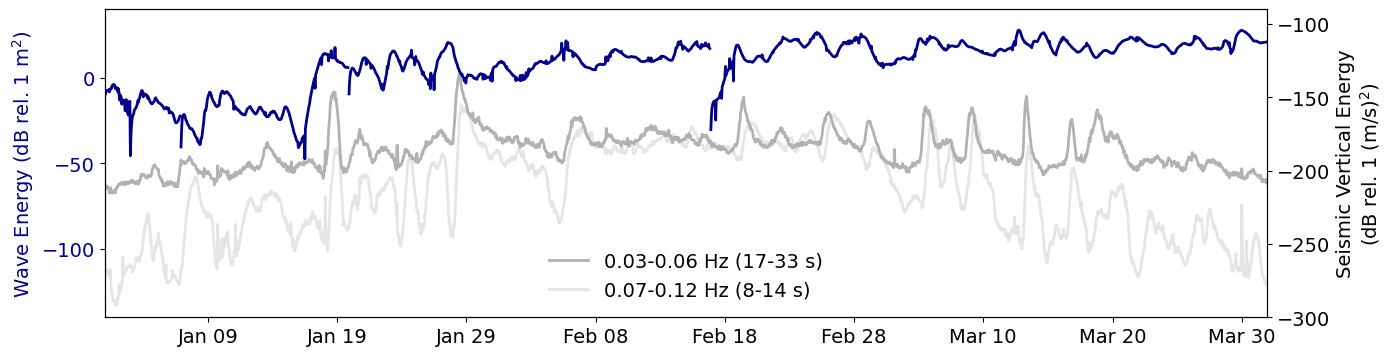

In [28]:

#WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import numpy as np

# File paths
file_paths = [
    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv' #Northwest sector, offshore
]
#file_paths = [
#    '/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_WEST2_25_HR.csv' #Ross Sea west sector
#]

fig, ax = plt.subplots(figsize=(15, 4))  # Adjust height as needed

for i, file_path in enumerate(file_paths):
    data = pd.read_csv(file_path)
    data['time_UTC2'] = pd.to_datetime(data['time_UTC2'], errors='coerce')
    data['time_UTC2_num'] = mdates.date2num(data['time_UTC2'])

    # Bar chart of Peak Period (not in dB – kept for visual context)
    #ax.bar(data['time_UTC2_num'], data['Tper_s_med_hr'],
    #       color='lightgray', alpha=0.1, zorder=0, label="Peak Period (s)")
    #ax.set_ylabel('Peak Period (s)', color='black', fontsize=14)
    #ax.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax.grid(True)

    # Left y-axis: Wave Energy in dB (now on main ax)
    wave_height = pd.to_numeric(data['Thgt_m_med_hr'], errors='coerce')
    wave_energy = wave_height ** 2
    wave_energy[wave_energy <= 0] = np.nan
    wave_energy_dB = 20 * np.log10(wave_energy)
    
    ax.plot(data['time_UTC2_num'], wave_energy_dB,
            '-', color='darkblue', linewidth=2, label="Wave Energy (dB)")
    ax.set_ylabel('Wave Energy (dB rel. 1 m$^2$)', color='darkblue', fontsize=14)
    ax.tick_params(axis='y', labelcolor='darkblue', labelsize=14)
    #ax.set_ylim([np.nanmin(wave_energy_dB) - 5, np.nanmax(wave_energy_dB) + 5])
    ax.set_ylim([-140, 40])

    # Right y-axis: Seismic Velocity Bands in dB
    ax_right = ax.twinx()
    bands = {
        'swellloband_hourly_avg': ('0.03-0.06 Hz (17-33 s)', 'black'), 
        'swellhiband_hourly_avg': ('0.07-0.12 Hz (8-14 s)', 'darkgray'),
        #'loband_vert_hourly_avg': ('0.12–1 Hz', 'green'),
        #'midband_vert_hourly_avg': ('1–2 Hz', 'darkorange'),
        #'hiband_vert_hourly_avg': ('2–4 Hz', 'lightcoral'),
    }
    
    # Plotting loop stays the same
    for column, (label, color) in bands.items():
        velocity = data[column].copy()
        velocity = velocity ** 2
        velocity[velocity <= 0] = np.nan
        velocity_dB = 20 * np.log10(velocity)
        ax_right.plot(
            data['time_UTC2_num'],
            velocity_dB,
            '-', 
            label=f'{label}', 
            color=color,
            linewidth=2,
            alpha=0.3
        )
    
    # Add this after the loop to customize the legend
    #ax_right.legend(fontsize=16)  # Change 12 to your desired font size

    legend = ax_right.legend(loc='lower center', fontsize=14, frameon=False) #lower right
    
    ax_right.set_ylabel('Seismic Vertical Energy\n(dB rel. 1 (m/s)$^2$)', color='black', fontsize=14)
    ax_right.tick_params(axis='y', labelcolor='black', labelsize=14)
    #ax_right.legend(loc='lower right', fontsize=10)
    ax_right.set_ylim([-300, -90])
    #ax_right.spines['right'].set_position(('outward', 60))
    #ax_right.spines['right'].set_color('black')
    ax_right.yaxis.set_label_position('right')
    ax_right.yaxis.set_ticks_position('right')
    
    # Set x-axis limits
    ax.set_xlim([data['time_UTC2_num'].min(), data['time_UTC2_num'].max()])
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax.tick_params(axis='x', labelcolor='black', labelsize=14)

    # Load sea ice data
    ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
    ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday.csv'
    sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
    sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

    start_date = pd.Timestamp('2015-01-01', tz='UTC')
    end_date = pd.Timestamp('2015-04-01 00:00:00', tz='UTC')
    sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
    sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

    sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
    sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

plt.xticks(rotation=45)
#plt.title('WW3 Offshore Wave Height and DR01 Station Energy Band Comparison')
#plt.tight_layout()
plt.savefig('/Users/em/PROJECTS/Swell/FIGS/DR01Swellband_WaveEOffshore_.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# update above with sea ice (updated ones) color sticks. 
# Add strain/stress time series from Matlab. 
# Update x-axis so the dates are 1 Jan, 15 Jan, etc. 

In [ ]:
# SEA ICE COLOR STICKS ONLY

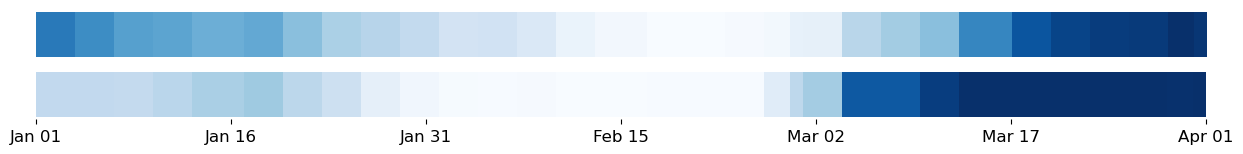

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load WaveWatch data only to set x-axis limits
wave_data = pd.read_csv('/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv')
wave_data['time_UTC2'] = pd.to_datetime(wave_data['time_UTC2'], errors='coerce')
wave_data['time_UTC2_num'] = mdates.date2num(wave_data['time_UTC2'])

# Load sea ice data
ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015NearShelfNearStation_nonblack_pixel_counts_multday.csv'
ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/2015WestCorr_nonblack_pixel_counts_multday_new.csv'

sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])

# Filter to match analysis window
start_date = pd.Timestamp('2015-01-01', tz='UTC')
end_date = pd.Timestamp('2015-04-01', tz='UTC')
sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()

sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])

# Normalize pixel counts for color mapping
norm_near = plt.Normalize(sea_ice_df_near['nonblack'].min(), sea_ice_df_near['nonblack'].max())
norm_west = plt.Normalize(sea_ice_df_west['nonblack'].min(), sea_ice_df_west['nonblack'].max())
cmap = plt.cm.Blues

# Create figure
fig = plt.figure(figsize=(15, 2))
left = 0.123
width = 0.78
height = 0.25
bottom_near = 0.1
bottom_west = 0.4

# Near Shelf Strip
strip_ax_near = fig.add_axes([left, bottom_near, width, height])
strip_ax_near.set_xlim(wave_data['time_UTC2_num'].min(), wave_data['time_UTC2_num'].max())
strip_ax_near.set_xticks([])
strip_ax_near.set_yticks([])
strip_ax_near.set_frame_on(False)

for i in range(len(sea_ice_df_near) - 1):
    val = sea_ice_df_near['nonblack'].iloc[i]
    color = cmap(norm_near(val))
    t1 = sea_ice_df_near['time_num'].iloc[i]
    t2 = sea_ice_df_near['time_num'].iloc[i + 1]
    strip_ax_near.fill_between([t1, t2], 0, 1, color=color, linewidth=0)

# West Corridor Strip
strip_ax_west = fig.add_axes([left, bottom_west, width, height])
strip_ax_west.set_xlim(wave_data['time_UTC2_num'].min(), wave_data['time_UTC2_num'].max())
strip_ax_west.set_xticks([])
strip_ax_west.set_yticks([])
strip_ax_west.set_frame_on(False)

for i in range(len(sea_ice_df_west) - 1):
    val = sea_ice_df_west['nonblack'].iloc[i]
    color = cmap(norm_west(val))
    t1 = sea_ice_df_west['time_num'].iloc[i]
    t2 = sea_ice_df_west['time_num'].iloc[i + 1]
    strip_ax_west.fill_between([t1, t2], 0, 1, color=color, linewidth=0)

# Optional: Add date ticks on bottom strip
strip_ax_near.set_xticks(pd.date_range(start='2015-01-01', end='2015-04-01', freq='15D'))
strip_ax_near.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
strip_ax_near.tick_params(axis='x', labelsize=12)

# Show plot
plt.show()


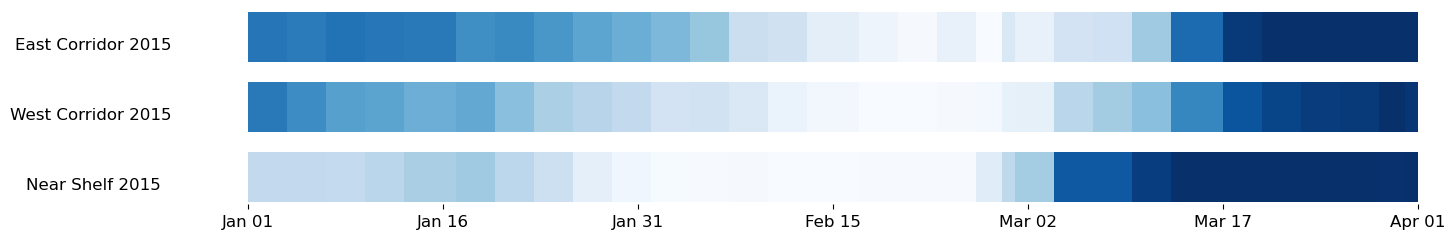

In [11]:
# ADDED EAST CORRIDOR

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Load WaveWatch data only to set x-axis limits
wave_data = pd.read_csv('/Users/em/PROJECTS/Swell/DATA/WaveWatch_2015_JanMar_All_NWEST_25_Comb_HR.csv')
wave_data['time_UTC2'] = pd.to_datetime(wave_data['time_UTC2'], errors='coerce')
wave_data['time_UTC2_num'] = mdates.date2num(wave_data['time_UTC2'])

# Load sea ice data
ice_file_near = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/NearShelfNearStation_nonblack_pixel_counts_multday_2015_Jan1toApr1_new.csv'
ice_file_west = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/WestCorr_nonblack_pixel_counts_multday_2015_Jan1toApr1_new.csv'
ice_file_east = '/Users/em/PROJECTS/SeaIce/SeaIceCorridor_Apr25/EastCorr_nonblack_pixel_counts_multday_2015_Jan1toApr1_new.csv'

sea_ice_df_near = pd.read_csv(ice_file_near, parse_dates=['Time_UTC'])
sea_ice_df_west = pd.read_csv(ice_file_west, parse_dates=['Time_UTC'])
sea_ice_df_east = pd.read_csv(ice_file_east, parse_dates=['Time_UTC'])

# Filter to match analysis window
start_date = pd.Timestamp('2015-01-01', tz='UTC')
end_date = pd.Timestamp('2015-04-01', tz='UTC')

sea_ice_df_near = sea_ice_df_near[(sea_ice_df_near['Time_UTC'] >= start_date) & (sea_ice_df_near['Time_UTC'] <= end_date)].copy()
sea_ice_df_west = sea_ice_df_west[(sea_ice_df_west['Time_UTC'] >= start_date) & (sea_ice_df_west['Time_UTC'] <= end_date)].copy()
sea_ice_df_east = sea_ice_df_east[(sea_ice_df_east['Time_UTC'] >= start_date) & (sea_ice_df_east['Time_UTC'] <= end_date)].copy()

sea_ice_df_near['time_num'] = mdates.date2num(sea_ice_df_near['Time_UTC'])
sea_ice_df_west['time_num'] = mdates.date2num(sea_ice_df_west['Time_UTC'])
sea_ice_df_east['time_num'] = mdates.date2num(sea_ice_df_east['Time_UTC'])

# Normalize pixel counts for color mapping
norm_near = plt.Normalize(sea_ice_df_near['nonblack'].min(), sea_ice_df_near['nonblack'].max())
norm_west = plt.Normalize(sea_ice_df_west['nonblack'].min(), sea_ice_df_west['nonblack'].max())
norm_east = plt.Normalize(sea_ice_df_east['nonblack'].min(), sea_ice_df_east['nonblack'].max())

cmap = plt.cm.Blues

# Create figure
fig = plt.figure(figsize=(15, 2.5))
left = 0.123
width = 0.78
height = 0.22
bottom_near = 0.1
bottom_west = 0.38
bottom_east = 0.66  # new top strip

# East Corridor Strip
strip_ax_east = fig.add_axes([left, bottom_east, width, height])
strip_ax_east.set_xlim(wave_data['time_UTC2_num'].min(), wave_data['time_UTC2_num'].max())
strip_ax_east.set_xticks([])
strip_ax_east.set_yticks([])
strip_ax_east.set_frame_on(False)

for i in range(len(sea_ice_df_east) - 1):
    val = sea_ice_df_east['nonblack'].iloc[i]
    color = cmap(norm_east(val))
    t1 = sea_ice_df_east['time_num'].iloc[i]
    t2 = sea_ice_df_east['time_num'].iloc[i + 1]
    strip_ax_east.fill_between([t1, t2], 0, 1, color=color, linewidth=0)

# West Corridor Strip
strip_ax_west = fig.add_axes([left, bottom_west, width, height])
strip_ax_west.set_xlim(wave_data['time_UTC2_num'].min(), wave_data['time_UTC2_num'].max())
strip_ax_west.set_xticks([])
strip_ax_west.set_yticks([])
strip_ax_west.set_frame_on(False)

for i in range(len(sea_ice_df_west) - 1):
    val = sea_ice_df_west['nonblack'].iloc[i]
    color = cmap(norm_west(val))
    t1 = sea_ice_df_west['time_num'].iloc[i]
    t2 = sea_ice_df_west['time_num'].iloc[i + 1]
    strip_ax_west.fill_between([t1, t2], 0, 1, color=color, linewidth=0)

# Near Shelf Strip
strip_ax_near = fig.add_axes([left, bottom_near, width, height])
strip_ax_near.set_xlim(wave_data['time_UTC2_num'].min(), wave_data['time_UTC2_num'].max())
strip_ax_near.set_xticks([])
strip_ax_near.set_yticks([])
strip_ax_near.set_frame_on(False)

for i in range(len(sea_ice_df_near) - 1):
    val = sea_ice_df_near['nonblack'].iloc[i]
    color = cmap(norm_near(val))
    t1 = sea_ice_df_near['time_num'].iloc[i]
    t2 = sea_ice_df_near['time_num'].iloc[i + 1]
    strip_ax_near.fill_between([t1, t2], 0, 1, color=color, linewidth=0)

# Optional: Add date ticks on bottom strip only
strip_ax_near.set_xticks(pd.date_range(start='2015-01-01', end='2015-04-01', freq='15D'))
strip_ax_near.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
strip_ax_near.tick_params(axis='x', labelsize=12)

# add corridor labels to the left of the color sticks
fig.text(0.02, bottom_east + height / 2, 'East Corridor 2014', va='top', ha='center', fontsize=12)
fig.text(0.02, bottom_west + height / 2, 'West Corridor 2014 ', va='top', ha='center', fontsize=12)
fig.text(0.02, bottom_near + height / 2, 'Near Shelf 2014',    va='top', ha='center', fontsize=12)

#plt.savefig('/Users/em/PROJECTS/SeaIce/FIGS/EastWestNearCorr_JantoMar2015.png', format='png', dpi=600, bbox_inches='tight')
plt.show()
